In [26]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [71]:
font_path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=font_path, size=12).get_name()
plt.rc('font', family=font_name)

In [28]:
file_paths = ['dataset D1.xlsx', 'dataset D2.xlsx', 'dataset D3.xlsx']
df1 = pd.read_excel(file_paths[1])

In [51]:
average_length = df1['text'].apply(lambda x: len(x)).mean()
print("Average sentence length:", average_length)

Average sentence length: 36.7666187072383


In [29]:
grouped_df = df1.groupby('types')
grouped_dfs = [group for _, group in grouped_df]

In [30]:
for i, df in enumerate(grouped_dfs):
    print(f"Group {i+1}:")
    print('샘플수', len(df))
    print('types 값:', df['types'].unique())

Group 1:
샘플수 36723
types 값: ['기쁨']
Group 2:
샘플수 38096
types 값: ['당황']
Group 3:
샘플수 32690
types 값: ['무감정']
Group 4:
샘플수 39423
types 값: ['분노']
Group 5:
샘플수 37537
types 값: ['불안']
Group 6:
샘플수 35608
types 값: ['상처']
Group 7:
샘플수 41255
types 값: ['슬픔']


In [61]:
pd.set_option('display.max_colwidth', None)
grouped_dfs[0].sample(10)

text  \
234987                                                   올림포스 산 아름다운 산기슭 가까이 자리 잡은 곳에 대해 들어 보았습니다.   
217353                                      왼쪽으로 놓고 보아도 임금 군이요, 오른쪽으로 놓고 보아도 임금 군이니, 훗날 왕이 되실 상이오.   
49065                                                        멋진 시를 지을 줄 알고 근사한 단어들을 구사하면서 말할 줄 알아.   
63942                                                                               주막까지 부지런히들 가지.   
143076                        그는 가루 부대에 걸터앉아 여자들이 어떻게 그를 좋아하고 그가 어떻게 그녀들을 마구 다루는지 한참 동안이나 설레발을 쳤다.   
160889                                                옛 절 앞 들과 산에 봄눈이 덮어 올 제 둘 만나는 맑은 멋을 알 이는 누구런가   
56362                                                                         실속을 차리게 되는 건 바로 나니까.   
96992                                                       늙어서 고향 산천에 눕게 되면 이 일을 말하며 아이들에게 자랑하리라.   
105346                                                      단언컨대, 이 여자와 장난치기 위해서는 어떤 돈이라도 지불하고 싶어.   
23934   우리의 용감한 멋진 불가리아 군사들이 칼을 빼 들고 눈빛을 번뜩이며 눈사태처럼 몰아치면서 불쌍한 세르비아 놈들과 멋이나 부리는 오스트리아 장교들을 흩어버리는 게.   

       types  
234987    기쁨  
217353    기쁨  
49065     기쁨  
63942     기쁨  
143076    기쁨  
160889    기쁨  
56362     기쁨  
96992     기쁨  
105346    기쁨  
23934     기쁨

In [31]:
# Initialize variables
max_length = 5000
emotion_sentences = []

# Iterate through each dataframe in grouped_dfs
for df in grouped_dfs:
    current_length = 0
    current_string = ""
    result = []
    # Iterate through each text in the dataframe
    for text in df['text']:
        # Check if adding the current text will exceed the maximum length
        if current_length + len(text) <= max_length:
            current_string += (text + ' ')
            current_length += len(text)+1
        else:
            # Add the current string to the result list and reset variables
            result.append(current_string.strip())
            current_string = text + ' '
            current_length = len(text)+1
    emotion_sentences.append(result)

In [32]:
len(emotion_sentences)

7

In [12]:
ACCESS_KEY = '#####USER_ACCESS_KEY#####' #your own key
ANALYSIS_CODE = 'ner'

In [13]:
import urllib3
import json

In [14]:
openApiURL = "http://aiopen.etri.re.kr:8000/WiseNLU"

accessKey = ACCESS_KEY
analysisCode = ANALYSIS_CODE

In [15]:
def get_etri_NERdata(text):
    try:
        requestJson = {
        "argument": {
            "text": text,
            "analysis_code": analysisCode
            }
        }
        
        http = urllib3.PoolManager()
        response = http.request(
            "POST",
            openApiURL,
            headers={"Content-Type": "application/json; charset=UTF-8", "Authorization" :  accessKey},
            body=json.dumps(requestJson)
        )
        
        if  response.status != 200:
            print("[error] %s" % response.data)
            return None
        
        result = str(response.data,"utf-8")
        return result
    
    except Exception as e:
        # Handle the exception
        print(e)
        return None

In [16]:
#emotion_label = ['기쁨', '당황', '분노', '불안', '상처', '슬픔']
emotion_label = ['기쁨', '당황', '무감정', '분노', '불안', '상처', '슬픔']
#emotion_label = ['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오']

In [17]:
emotion_ner = {}
emotion_ner_counts = {}

for i in range(len(emotion_sentences)):
    sentences = emotion_sentences[i]
    NE_dict = {}
    sentence_with_NE_counts = 0
    for sentence in tqdm(sentences):
        result = get_etri_NERdata(sentence)
        if result != None:
            j = json.loads(result)
            for sent in j['return_object']['sentence']:
                NE_found = False  # 현재 문장에서 개체명을 찾았는지 여부
                for item in sent['NE']:
                    NE_tag = item['type']
                    word = item['text']
                    if NE_tag not in NE_dict:
                        NE_dict[NE_tag] = []
                    NE_dict[NE_tag].append(word)
                    NE_found = True
                if NE_found:
                    sentence_with_NE_counts += 1
    emotion_ner[emotion_label[i]] = NE_dict
    emotion_ner_counts[emotion_label[i]] = sentence_with_NE_counts

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

  0%|          | 0/303 [00:00<?, ?it/s]

In [18]:
emotion_ner.keys()

dict_keys(['기쁨', '당황', '무감정', '분노', '불안', '상처', '슬픔'])

In [8]:
emotion_ner_count

{'기쁨': 20338,
 '당황': 19386,
 '무감정': 19061,
 '분노': 19899,
 '불안': 19277,
 '상처': 17665,
 '슬픔': 21468}

In [9]:
for key, values in emotion_ner.items():
    print('####',key,'####', end='\t')
    print('개체명태그', len(values.keys()),'종류', end='\t')
    unique_word_count = 0
    word_count = 0
    for tag, words in values.items():
        unique_word_count += len(set(words))
        word_count += len(words)
    print(unique_word_count,'단어', end='\t')
    print(word_count,'회')
    

#### 기쁨 ####	개체명태그 107 종류	2111 단어	43879 회
#### 당황 ####	개체명태그 98 종류	1707 단어	38722 회
#### 무감정 ####	개체명태그 110 종류	2037 단어	45772 회
#### 분노 ####	개체명태그 104 종류	1854 단어	38770 회
#### 불안 ####	개체명태그 104 종류	1865 단어	38943 회
#### 상처 ####	개체명태그 98 종류	1637 단어	34700 회
#### 슬픔 ####	개체명태그 107 종류	1867 단어	43590 회


In [63]:
import matplotlib.pyplot as plt

def draw_bar_graph(emotion, top_n):
    
    # 각 키에 대한 값 리스트의 길이 계산
    length_dict = {key: len(values) for key, values in emotion_ner[emotion].items()}

    # 키와 값을 추출하고 값을 기준으로 내림차순 정렬
    sorted_items = sorted(length_dict.items(), key=lambda item: item[1], reverse=True)

    # 상위 top_n개 항목만 선택
    sorted_items_top = sorted_items[:top_n]

    # 상위 n개 항목을 다시 오름차순으로 정렬하여 높은 빈도의 개체가 위에 오도록 함
    sorted_items_top_reversed = sorted(sorted_items_top, key=lambda item: item[1])

    # 정렬된 키와 값을 분리
    keys, values = zip(*sorted_items_top_reversed)

    # 막대 그래프 그리기
    plt.figure(figsize=(6, 4), dpi=300)
    bars = plt.barh(keys, values, color='skyblue')

    # 막대 오른쪽 끝에 숫자 표시
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
                 f'{bar.get_width()}', 
                 va='center', ha='left')

    plt.xlabel('어휘 수')
    title = f'D2 \'{emotion}\' 텍스트의 주요 개체명 어휘 유형 (상위 10 종류)'
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

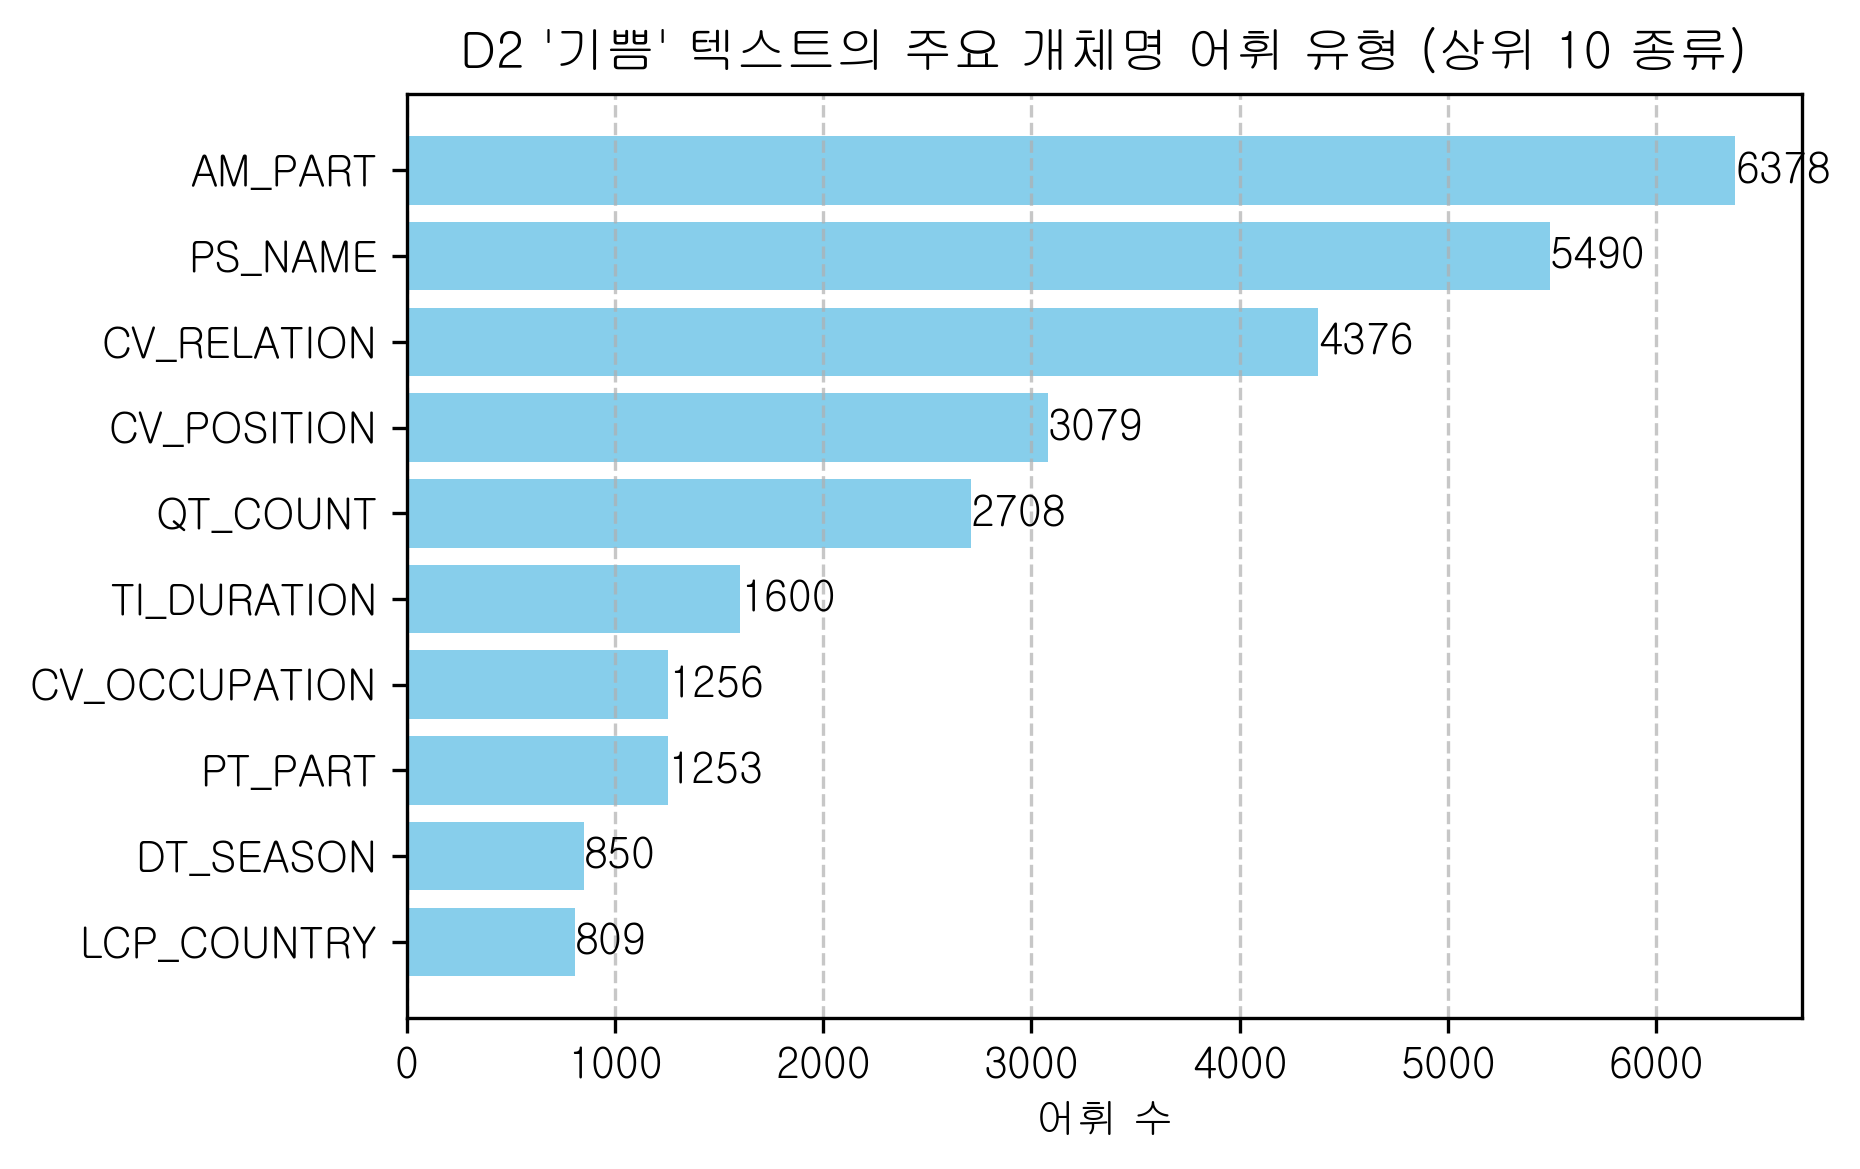

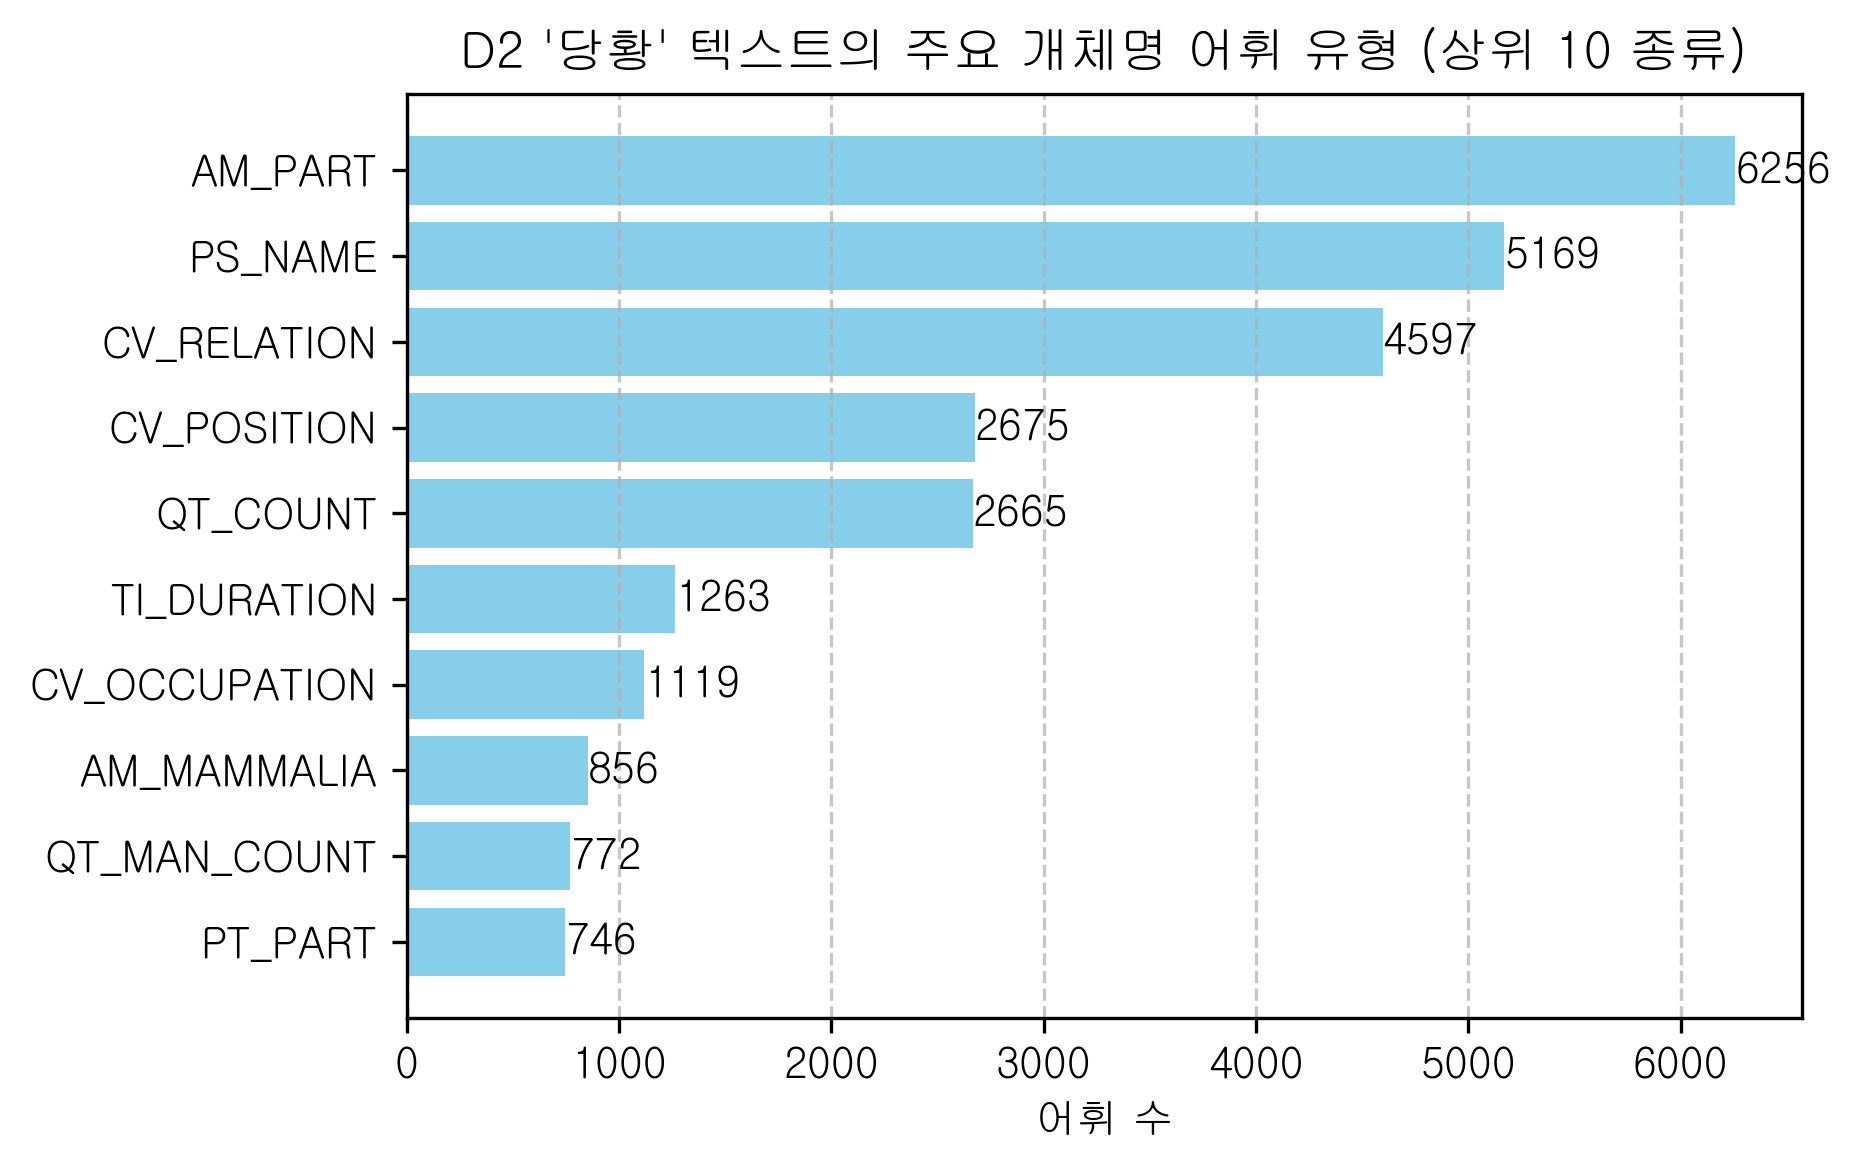

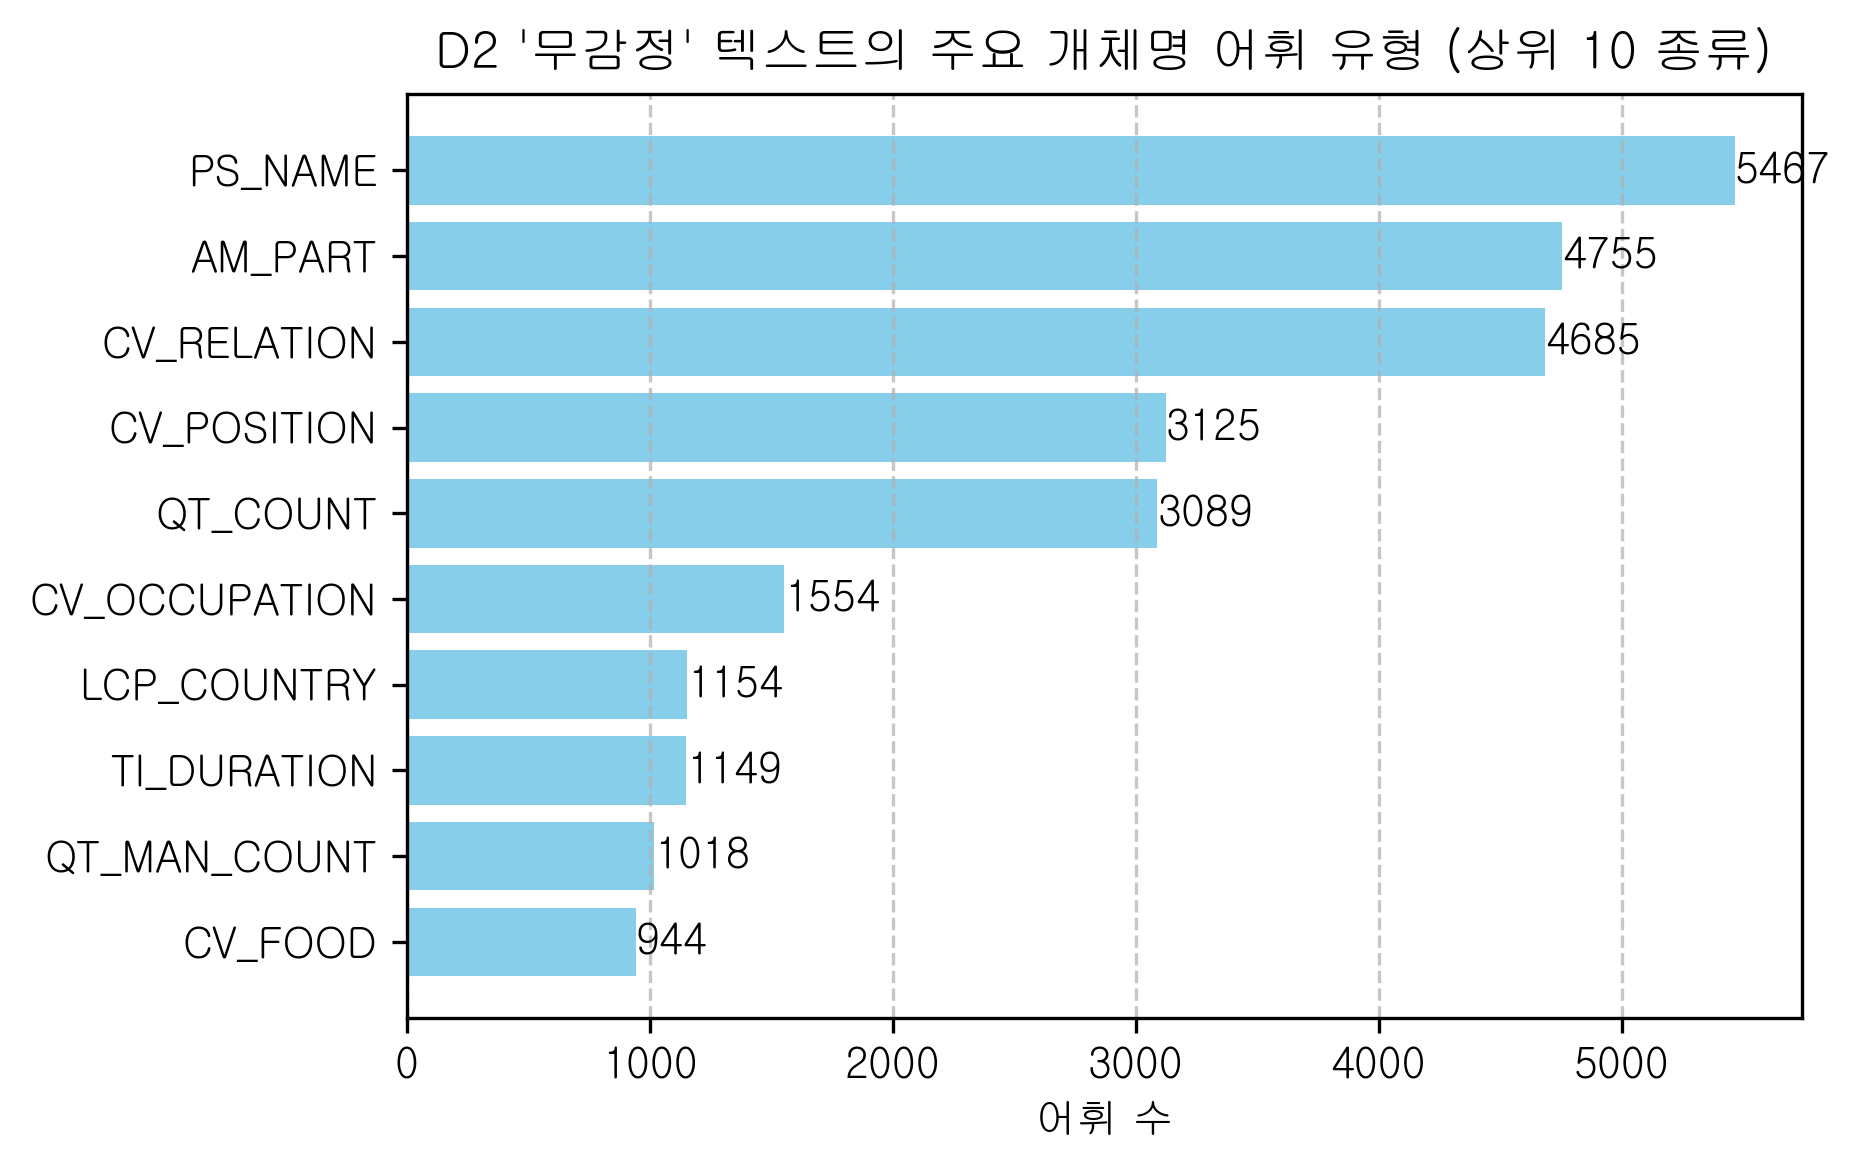

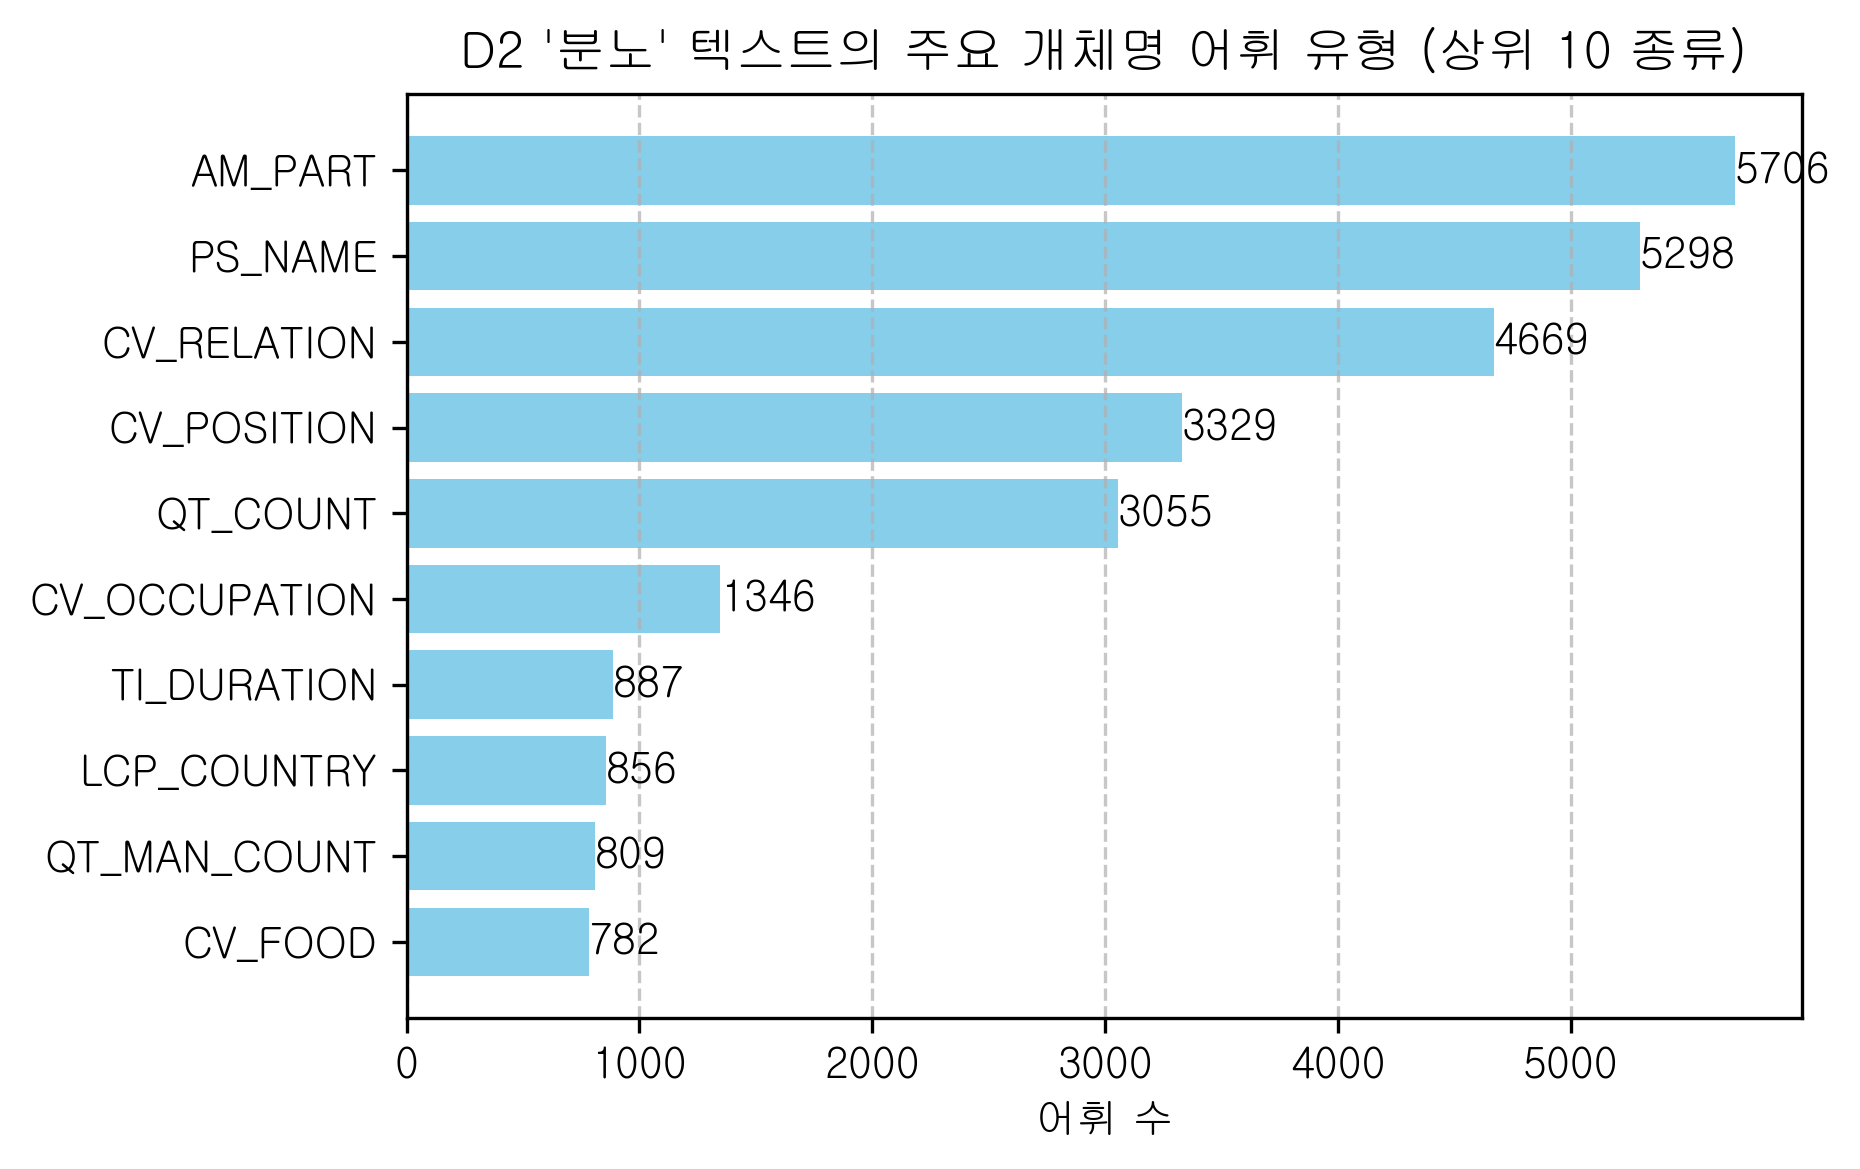

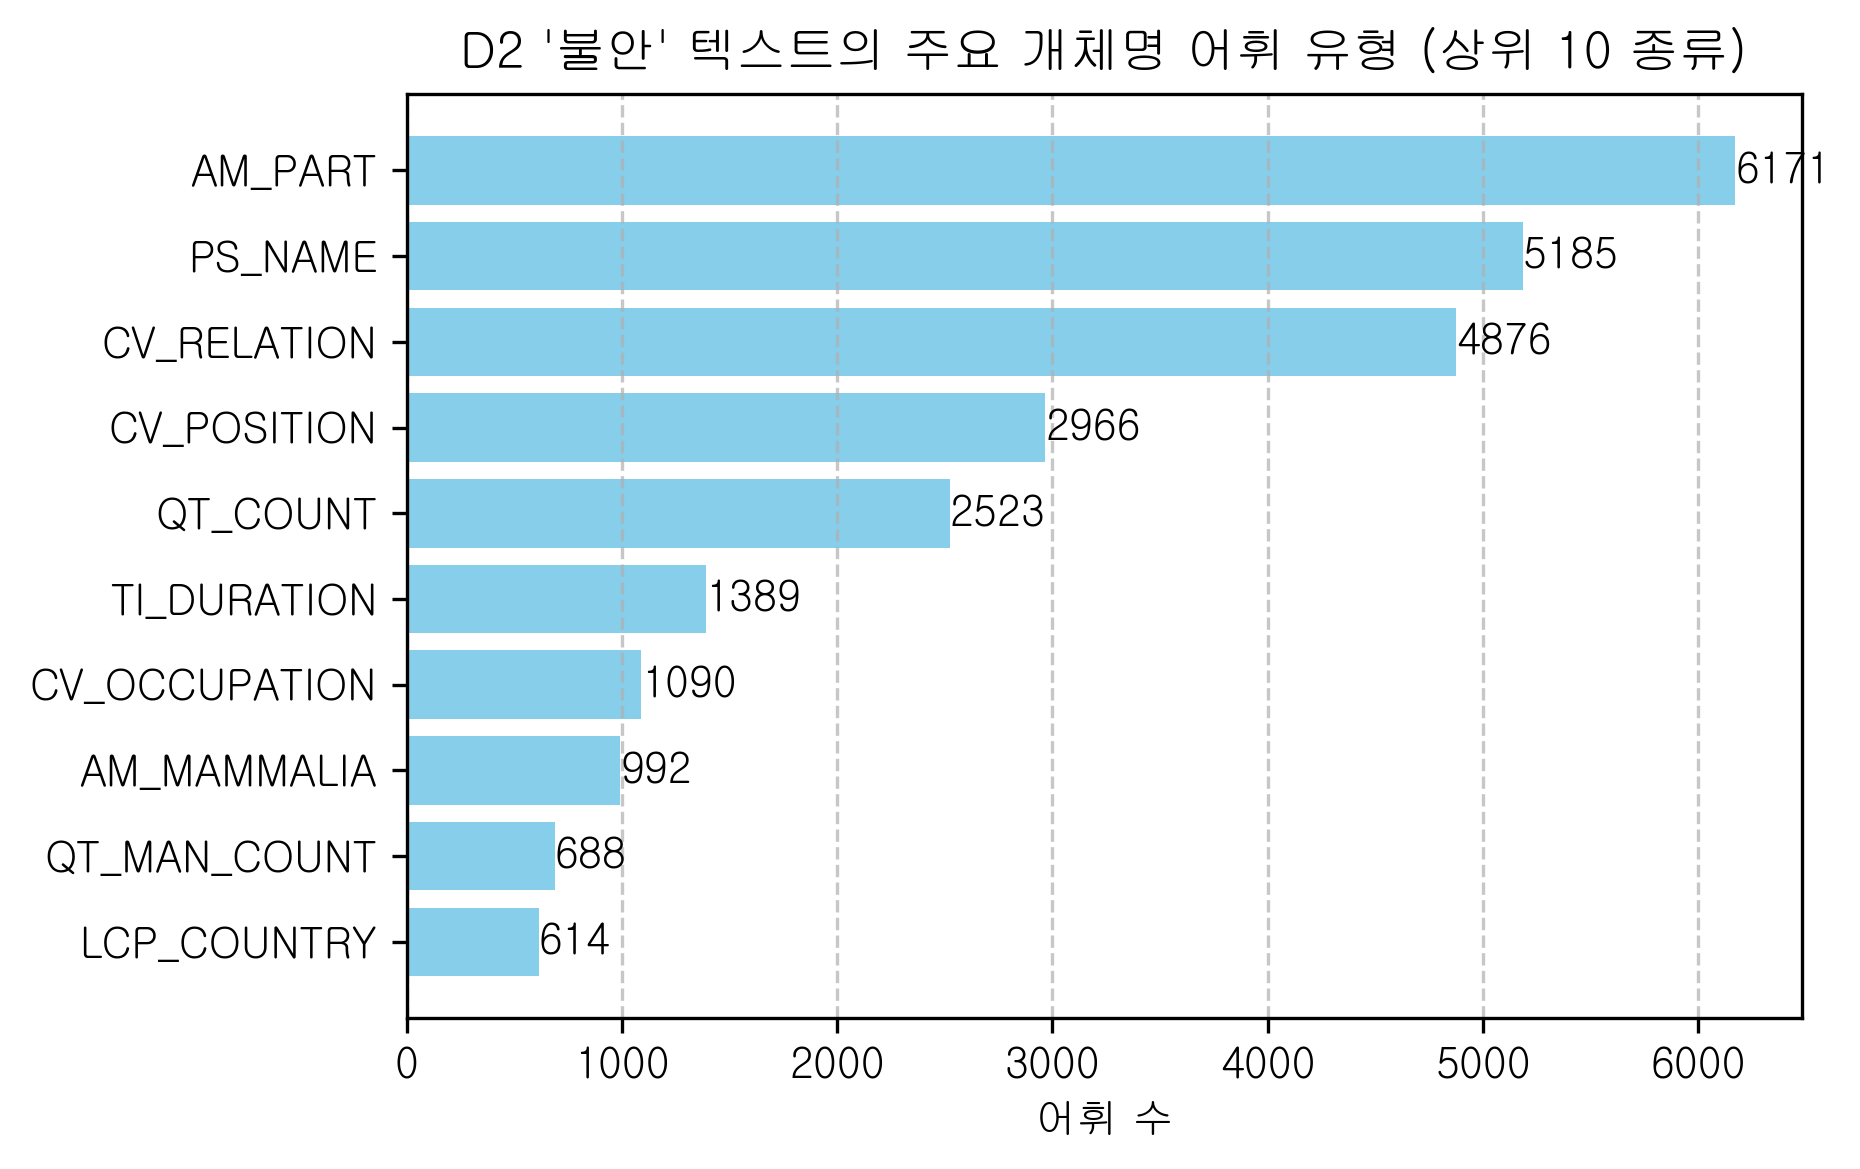

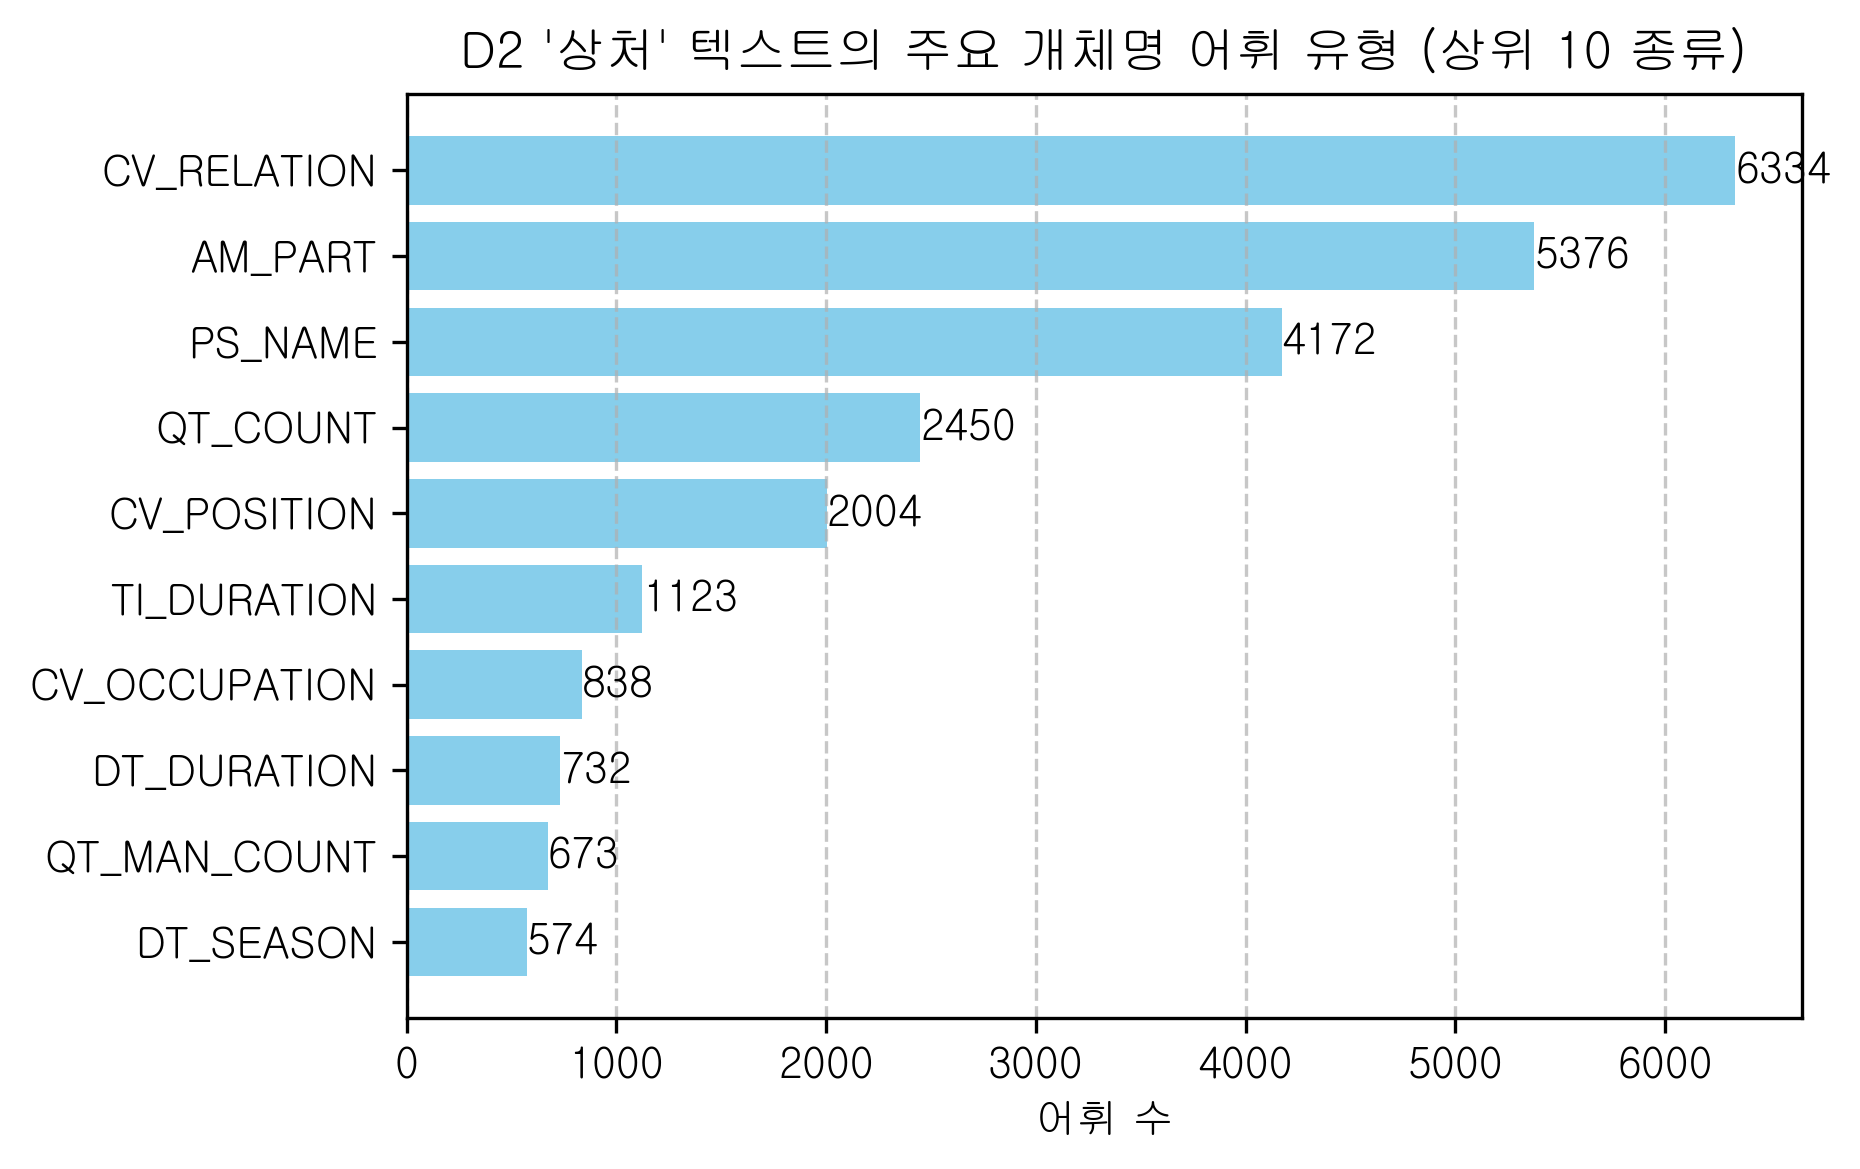

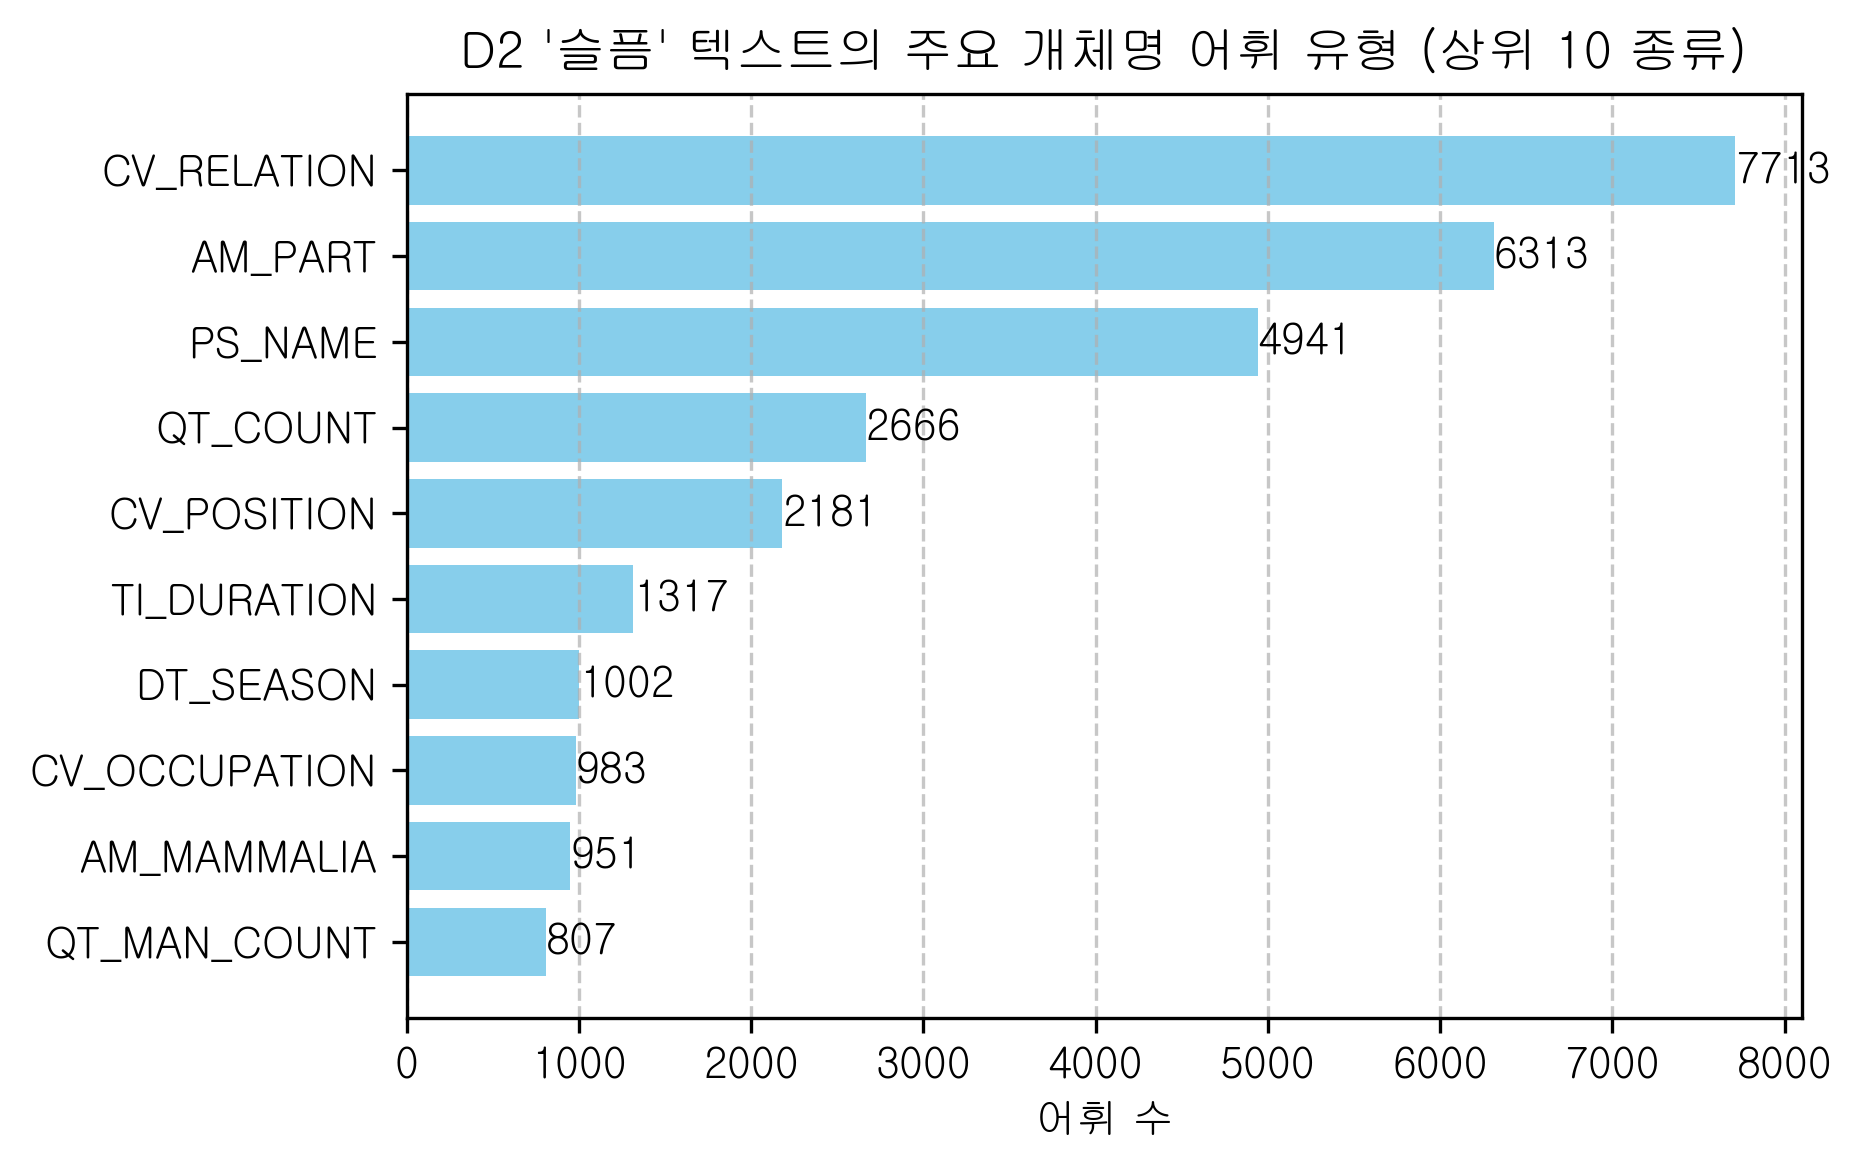

In [64]:
for emotion in emotion_ner.keys():
    draw_bar_graph(emotion, 10)

In [68]:
from collections import Counter

# '기쁨' 감정의 'CV_RELATION' 데이터에서 단어들의 빈도수 계산
#word_counts = Counter(emotion_ner['기쁨']['AM_PART'])
#word_counts = Counter(emotion_ner['기쁨']['PS_NAME'])
word_counts = Counter(emotion_ner['기쁨']['CV_RELATION'])

# 빈도수가 높은 순으로 단어들 정렬
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
for word, count in sorted_word_counts:
    print(f"{word}: {count}")

친구: 386
아버지: 385
어머니: 306
아들: 258
아내: 257
딸: 196
남편: 156
부인: 140
부모: 137
부부: 95
새끼: 84
형제: 81
연인: 80
언니: 79
누이: 75
동생: 69
엄마: 66
이웃: 66
자식: 66
신랑: 63
따: 61
형: 56
가족: 54
부친: 44
모친: 40
고모: 39
할머니: 37
누나: 36
외삼촌: 36
부자: 36
벗: 35
오빠: 34
쌍둥이: 33
아버님: 31
약혼녀: 28
여동생: 27
형님: 27
자매: 25
동료: 25
제자: 24
외동딸: 23
어머님: 21
아빠: 20
친척: 20
아드: 20
사돈: 20
마누라: 20
신부: 19
삼촌: 19
처: 18
할배: 18
며느리: 18
플라테: 15
인척: 12
영감: 12
사촌: 12
아우: 11
누이동생: 11
오라비: 11
따님: 11
친지: 11
애인: 11
아줌마: 10
막내: 10
아드님: 10
손녀: 10
손주: 10
맏사위: 10
벗 로더리히로군: 10
친아들: 9
이모: 9
할아버지: 9
이종: 9
사촌네: 9
누님: 9
동지: 9
매부: 9
오라버니: 9
어미: 9
딸랑딸: 9
막내둥이: 8
스승: 8
문하생: 8
남편감: 8
조카야: 8
할망구: 8
아주머니: 8
유모: 8
친정: 7
원수: 5
사위: 5


In [66]:
from collections import Counter

# 상위권 주요 단어들 추출 (예시로 상위 5개 단어를 추출한다고 가정)
top_words = [word for word, count in Counter(emotion_ner['기쁨']['AM_PART']).most_common(5)]

# grouped_dfs[0]의 'text' 열에서 상위권 주요 단어들이 포함된 문장 찾기
matching_sentences = []
for sentence in grouped_dfs[0]['text']:
    if any(word in sentence for word in top_words):
        matching_sentences.append(sentence)

# 결과 출력
for sentence in matching_sentences:
    print(sentence)

눈물을 흘리며 늘 기다리던 너였지.
그대의 천상의 눈길에 어떤 것들은 깃털 달린 나팔로, 또 어떤 것들은 금속으로 된 새로, 더할 나위 없이 아름답고 비할 데 없는 음악을 만들어, 총알들이 자기의 여왕에게, 새들이 여명의 여신에게, 트럼펫이 지혜의 여신에게, 그리고 꽃들이 꽃의 여신에게 하듯, 그렇게 그대에게 인사를 하는군요.
네 동생 관목에서 보석 같은 귀한 꽃을 꺾어다가 네 신랑에게 그것을 가슴에 달게 하려무나.
나의 과학과 너희 둘 사이의 공감이 그의 몸 안에 작용해서 그는 이제 보통 남자들과는 다른 남자가 된 거다.
하며 성오는 득수의 손에 매달리더니 어느 틈엔가 물에 퍼진 콩알만큼 뚝 잘라 그냥 냉큼 입에 집어넣는다.
하며 입을 다시는 성오의 얼굴에는 비로소 웃음이 떠오른다.
산 저물녘 기운은 중턱에 모여들고 시냇물 깊숙한 곳 봄눈이 맑아라
그녀의 얼굴은 지난번보다 더 잘 보였는데, 그는 순진하고 상큼한 그 표정에 깊은 감동을 받았다.
그들은 당신을 칭송했어요, 당신이 그 말을 들었더라면, 오늘 당신 얼굴이 빨개졌을 텐데요!
산 저물녘 기운은 중턱에 모여들고 시냇물 깊숙한 곳 봄눈이 맑아라
오래전 백마를 탄 쌍둥이 오빠들이 손에 빛나는 횃불을 들고 축복하면서 내게 신부인 당신을 데려다주었소.
밀랍 색이 되어 나는 바라보았네, 덤불 속 한 작은 빛줄기가 그녀의 미소와 그녀의 가슴에서 나비처럼 날아다니는 것을 장미 나무의 파리처럼.
내 입술 아래 떨고 있는 가여운 것들, 그녀의 그 두 눈에 나는 부드럽게 입 맞추었네.
폭풍우는 내가 항해에 눈뜬 것을 축복해 주었네.
코르크 마개보다 더 가벼이 나는 춤추었네, 영원히 흔들리는 희생자들의 배라 일컫는 물결 위에서, 열흘 밤을, 항구 불의 멍청한 눈빛 그리워하지도 않으며!
부인, 가엾은 내가 당신의 무릎을 베고 당신에게 가슴에 품은 열정을 설명하도록 허락해 주오.
당신은 내 마음을 당신 손에 쥐고 있습니다.
황갈색 몸통, 투명한 날개, 말벌처럼 가느다란 허리에 꽁무니에 뾰족한 침이 달린 것.
활활 타오르는 뜨거

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def draw_wordcloud(emotion):
    print('####',emotion,'####')
    text = ''
    for tag, words in emotion_ner[emotion].items():
        if tag != 'QT_COUNT':
            text += ' '.join(words)
        
    # 텍스트를 공백 기준으로 분리하여 단어의 출현 빈도 계산
    word_counts = Counter(text.split())

    # WordCloud 객체 생성 시, 빈도 정보와 함께 이미지 크기를 높여서 고해상도로 설정
    wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate_from_frequencies(word_counts)

    # 워드 클라우드 표시, dpi 값을 높여서 해상도 개선
    plt.figure(figsize=(10, 6), dpi=300)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 기쁨 ####


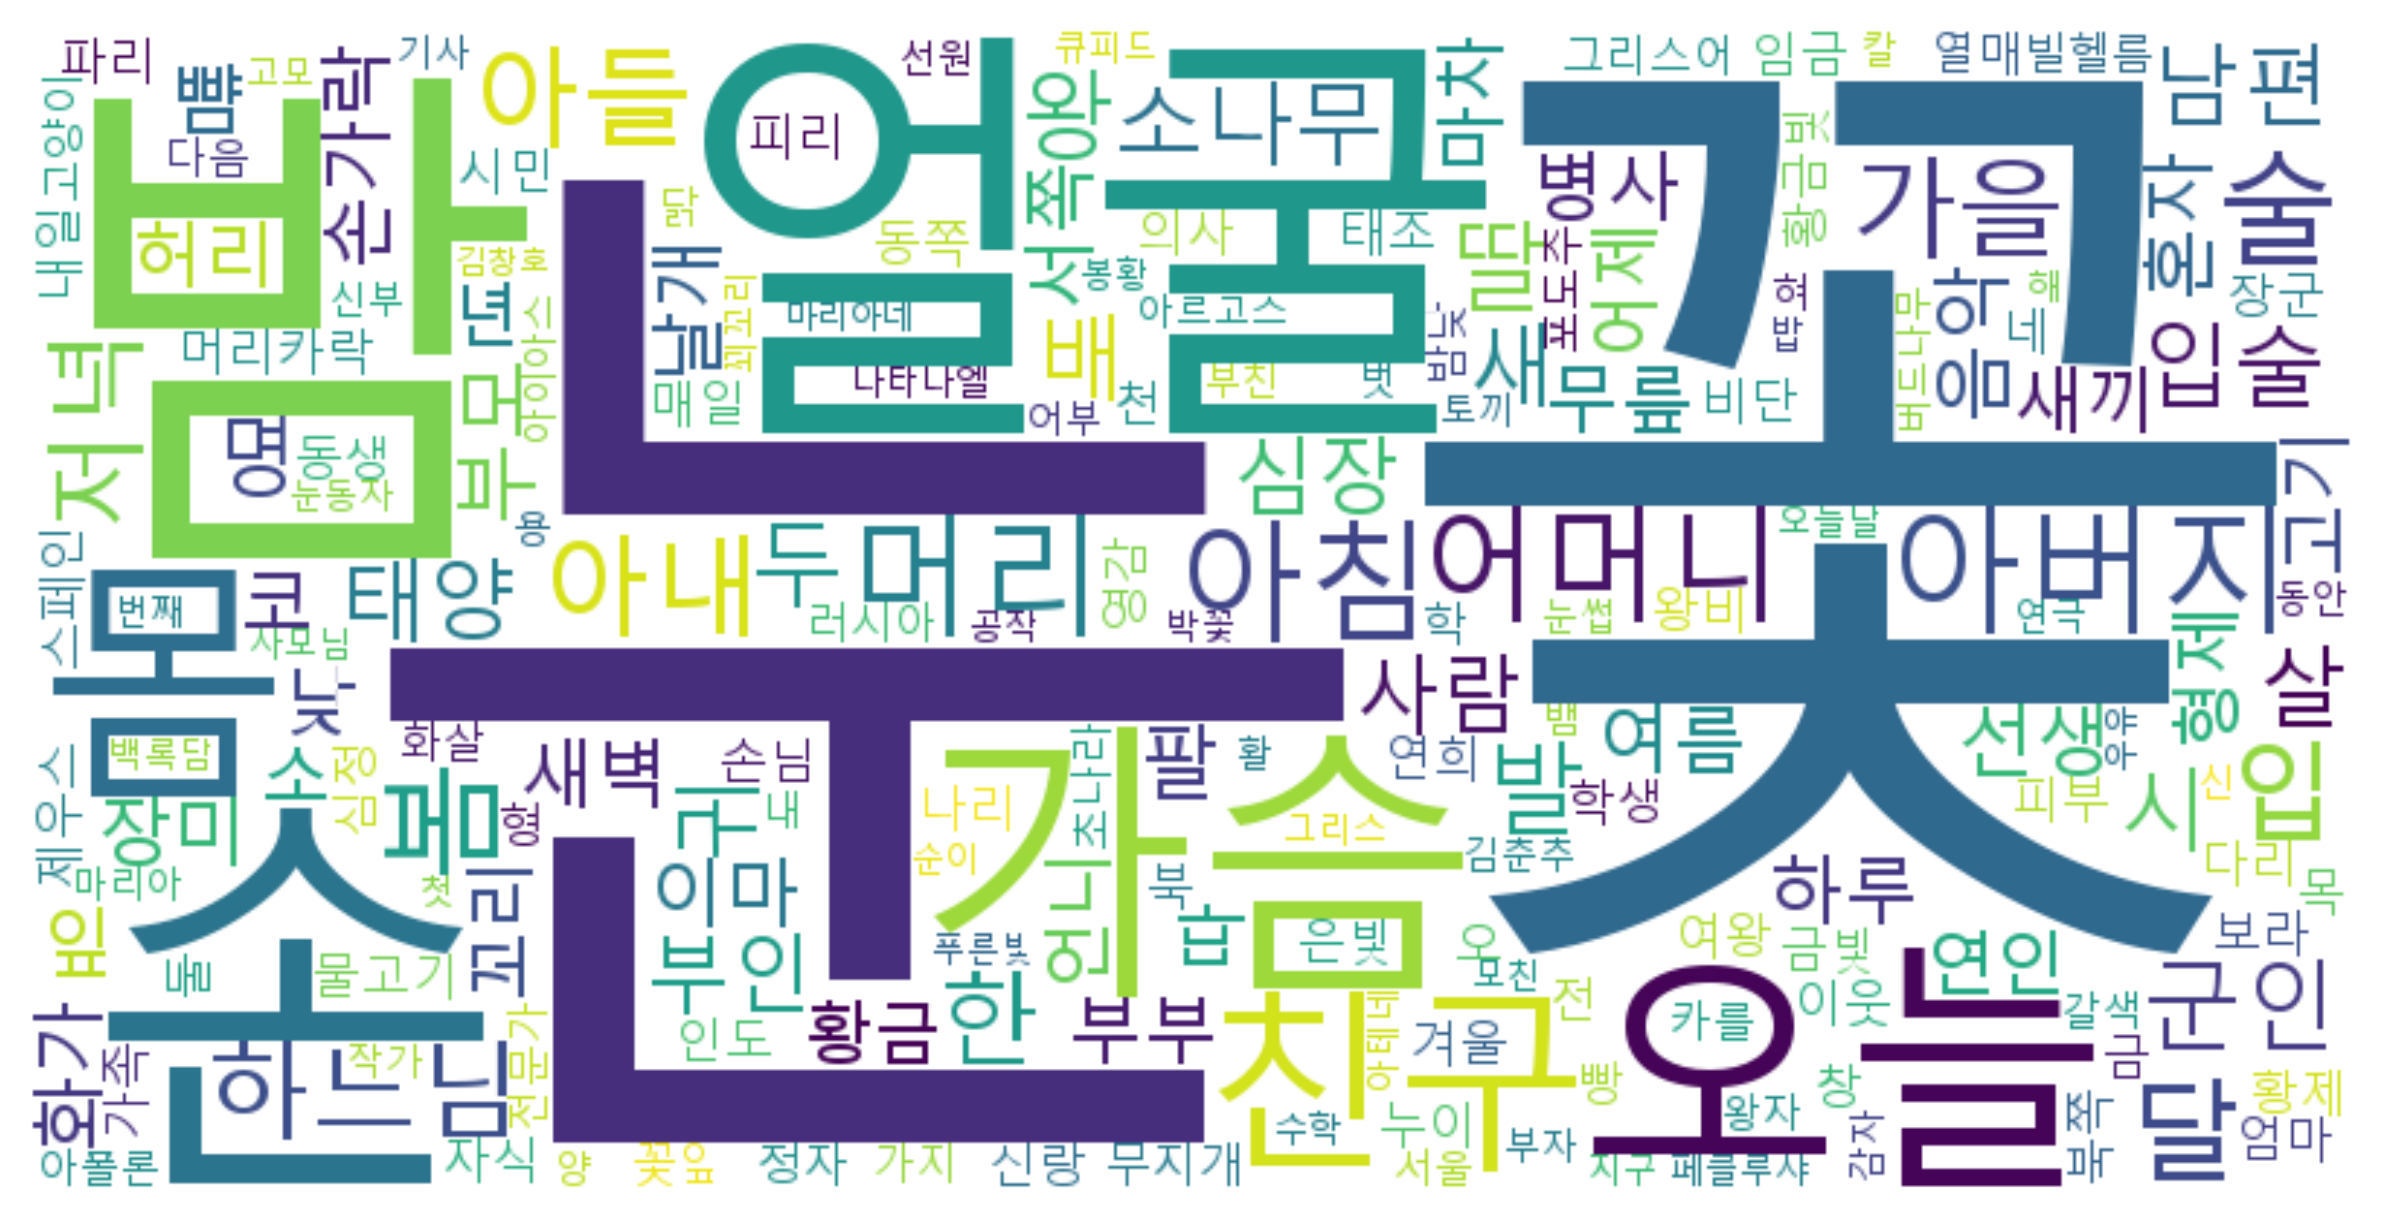

#### 당황 ####


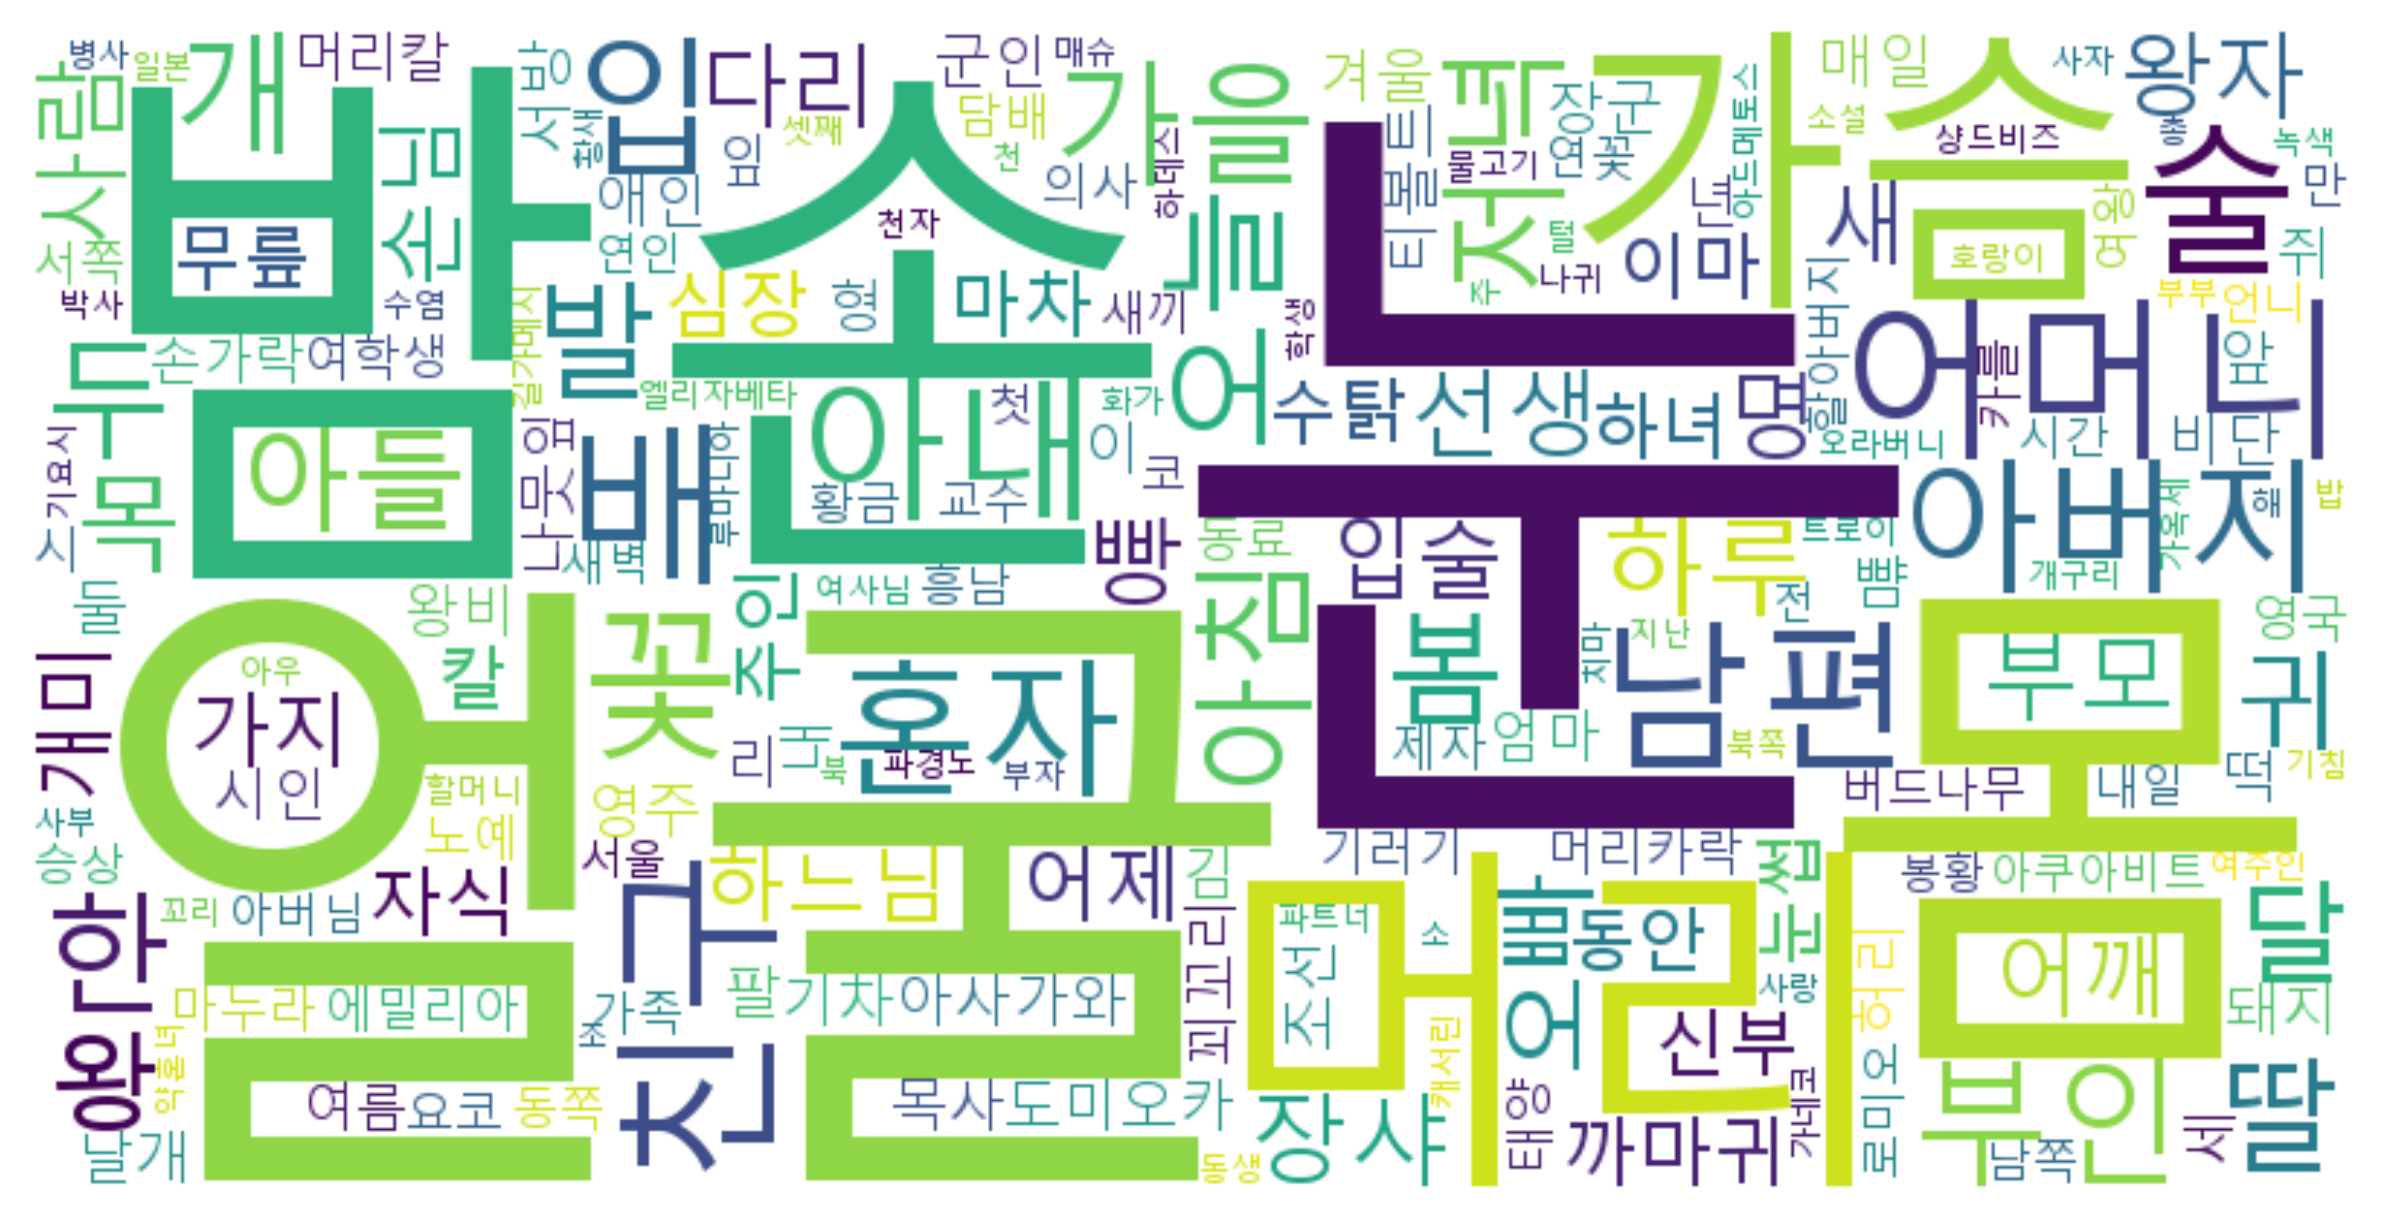

#### 무감정 ####


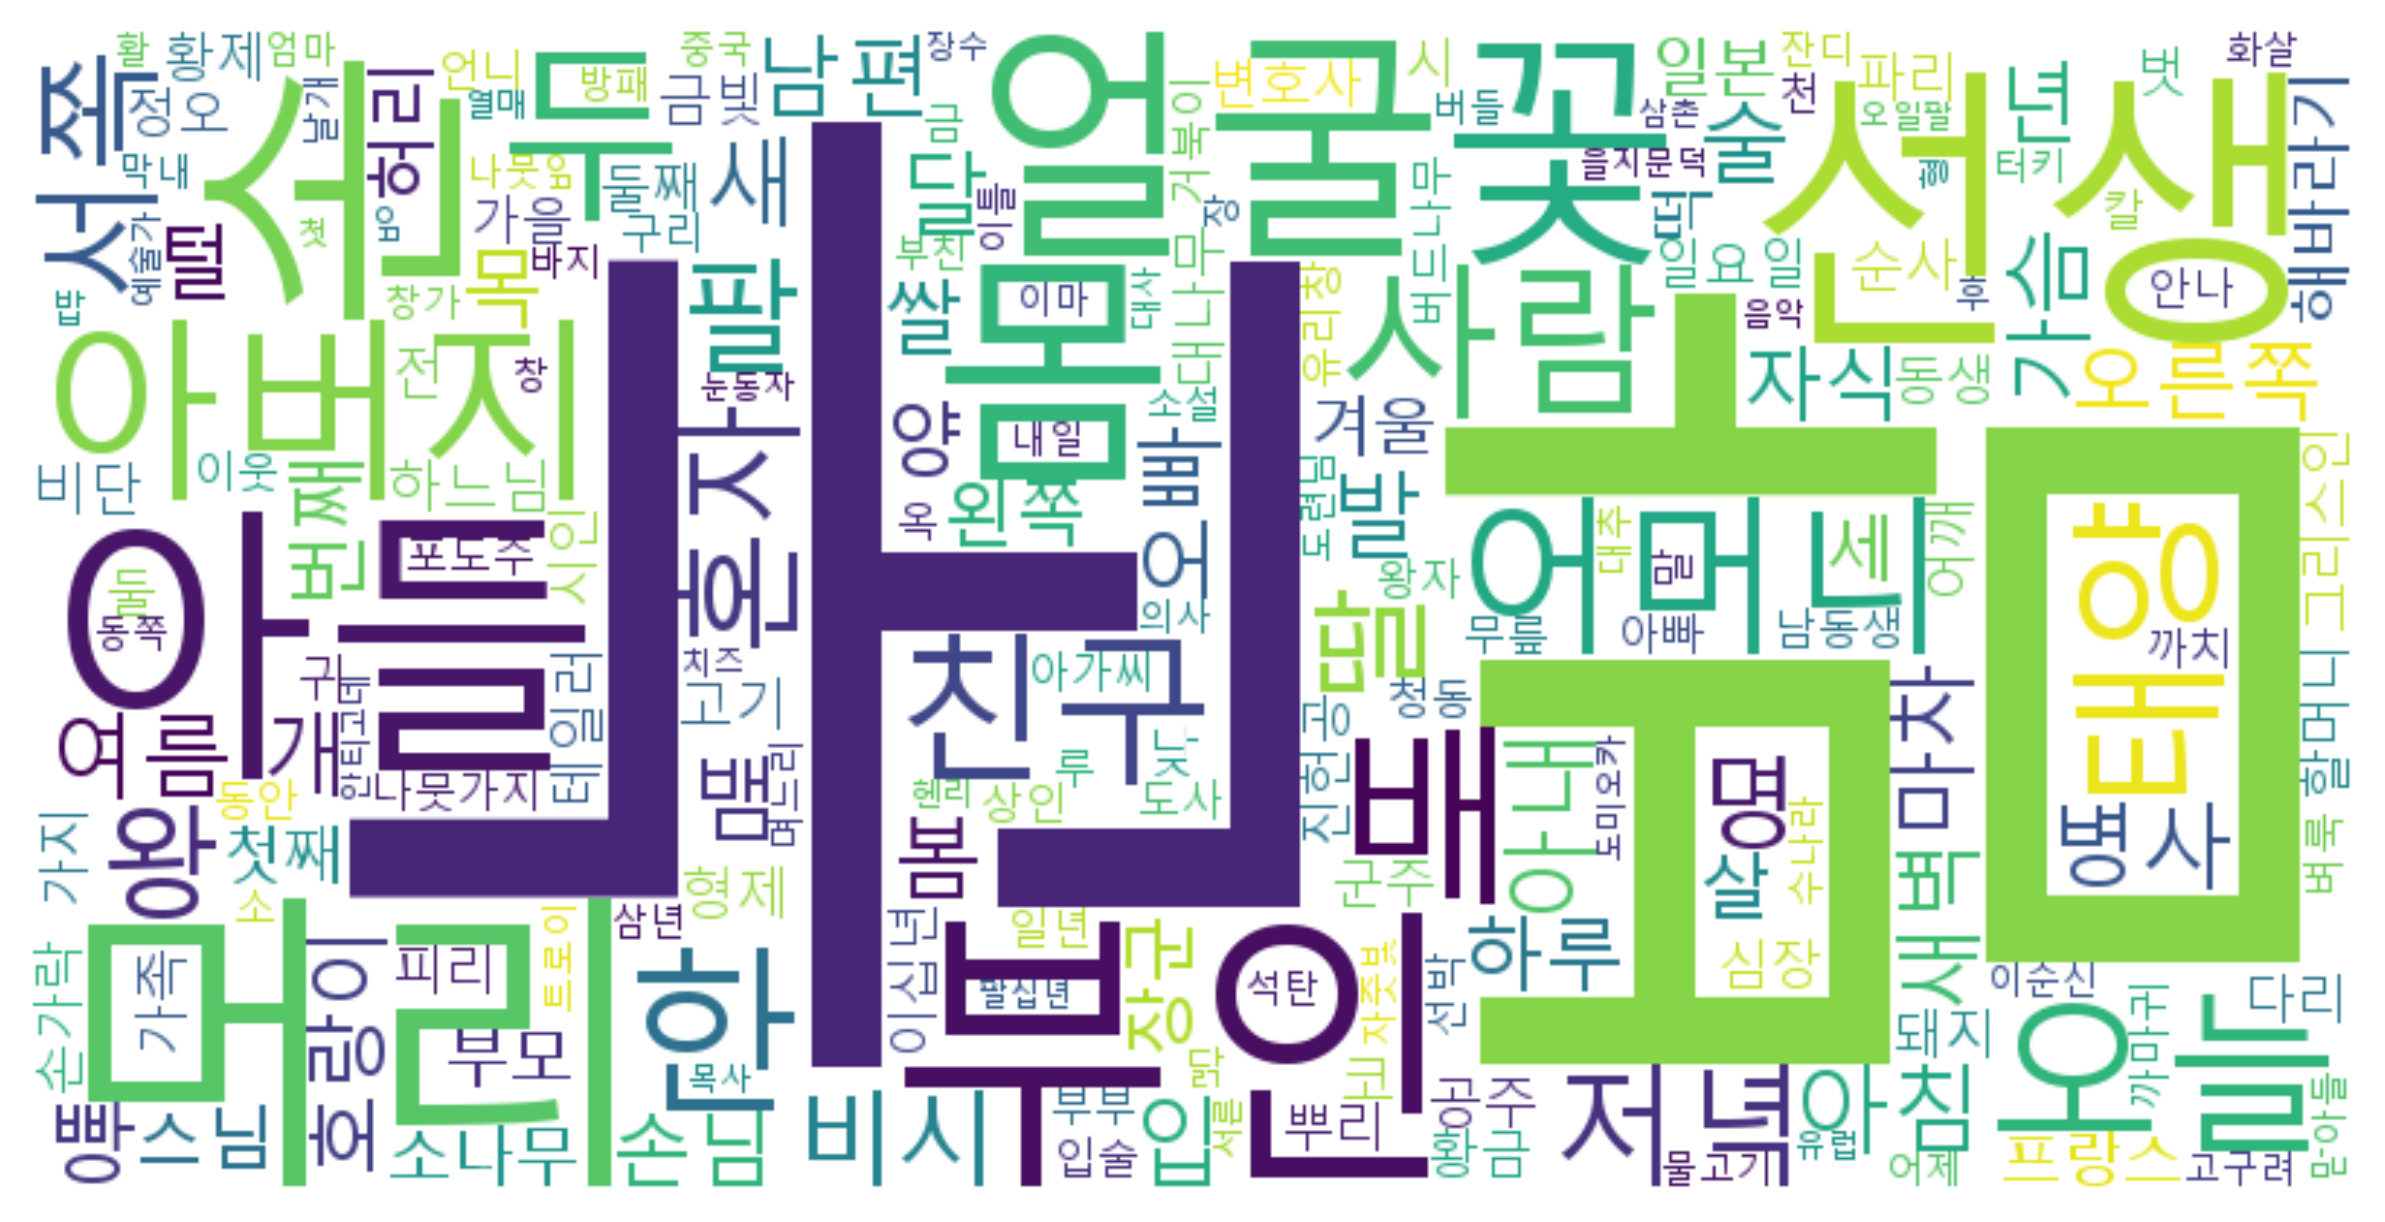

#### 분노 ####


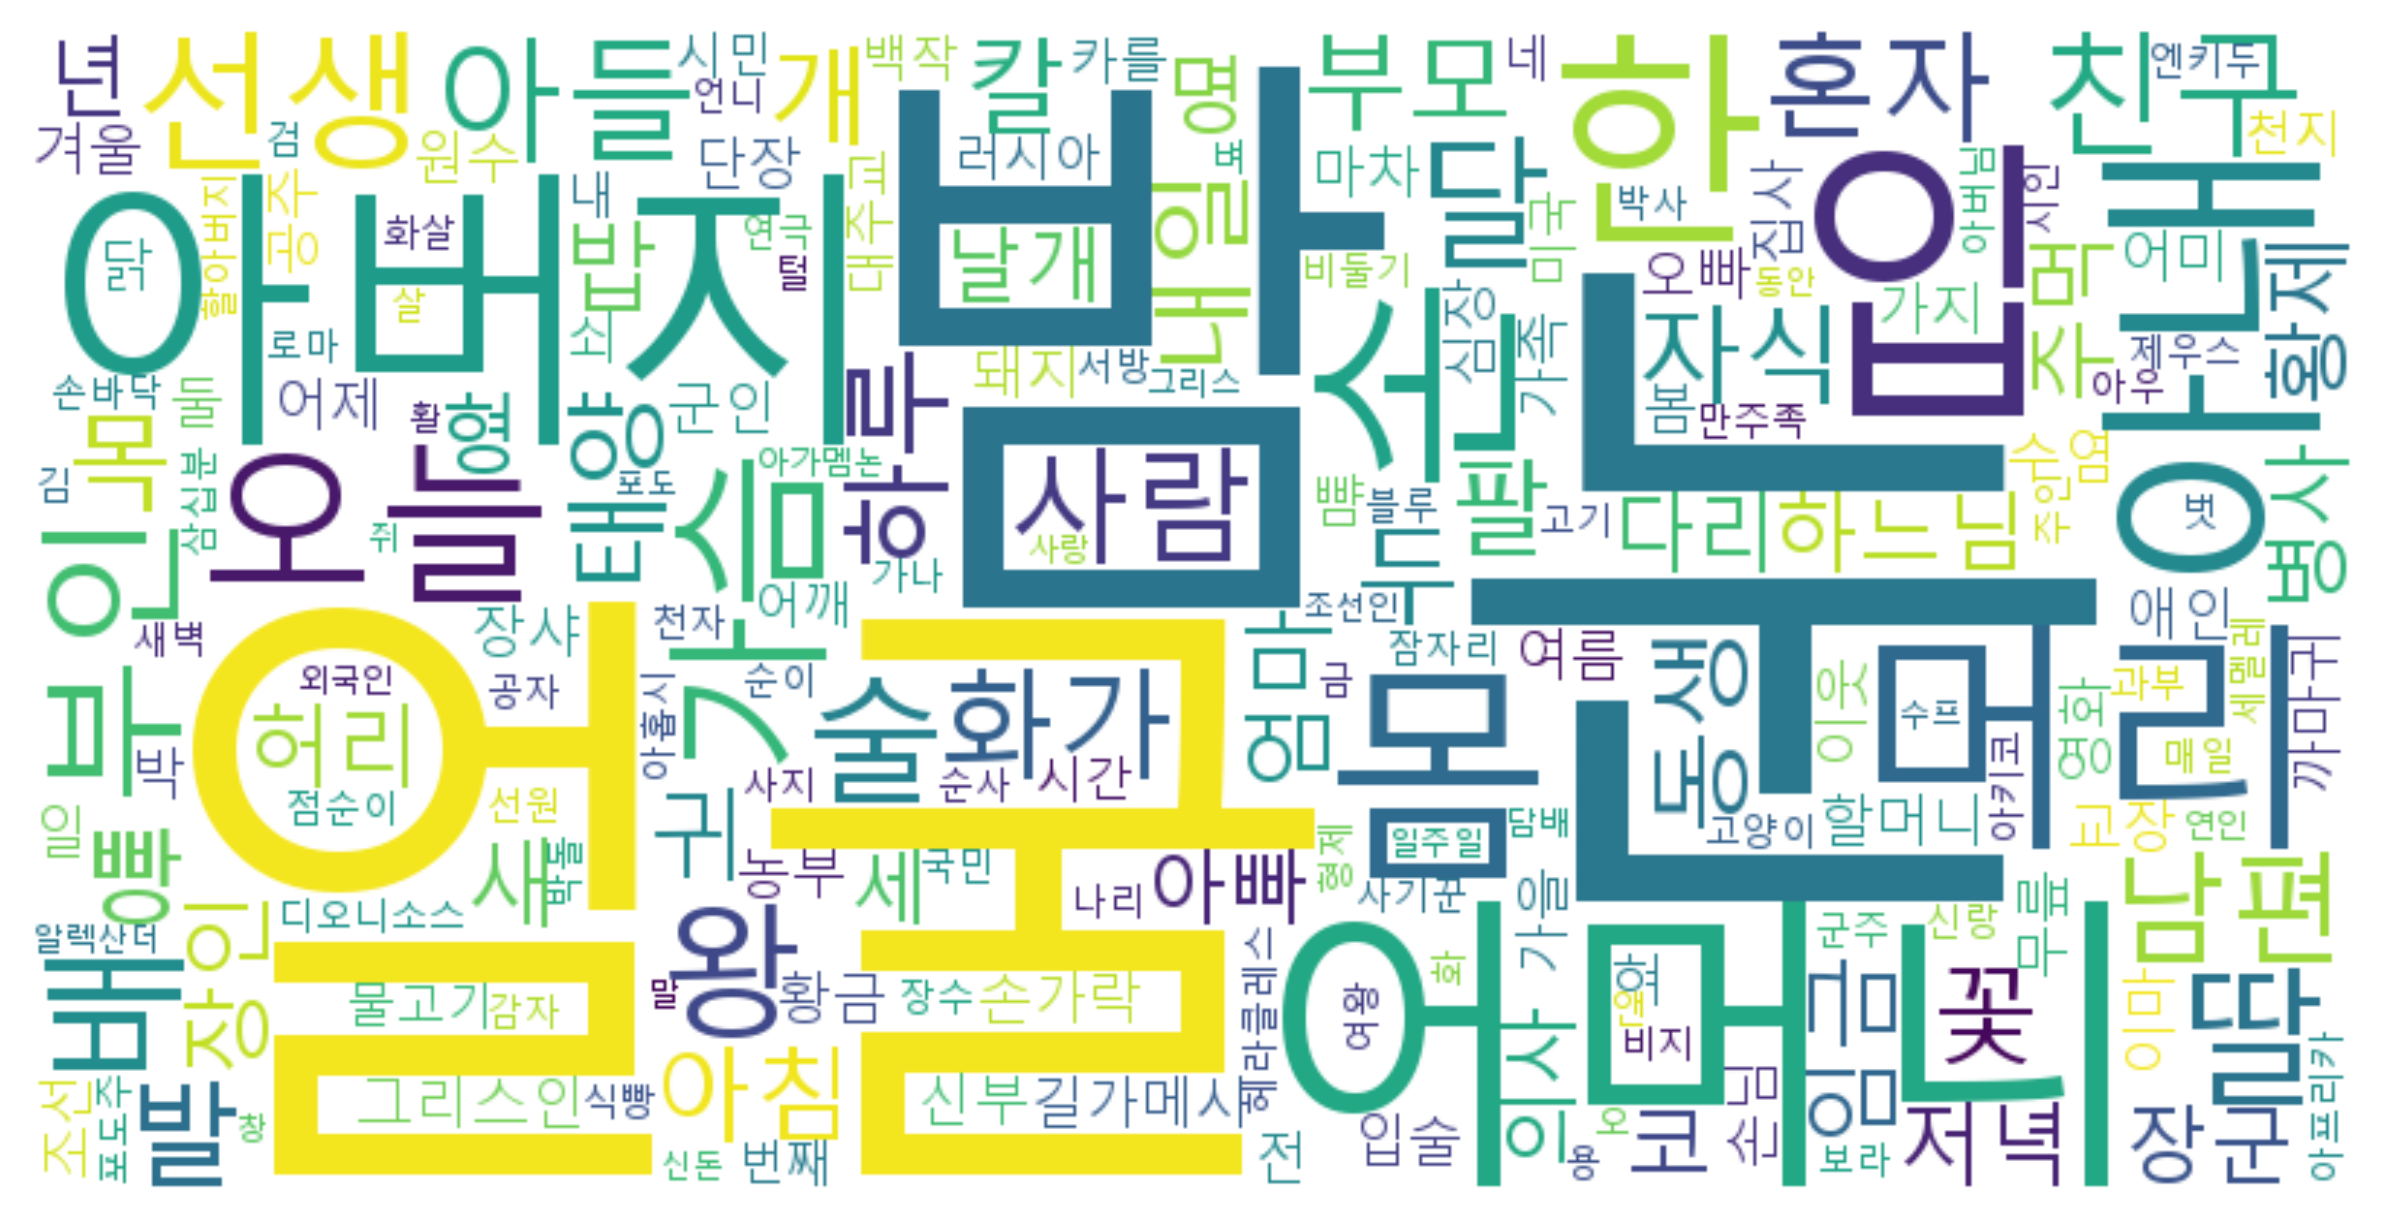

#### 불안 ####


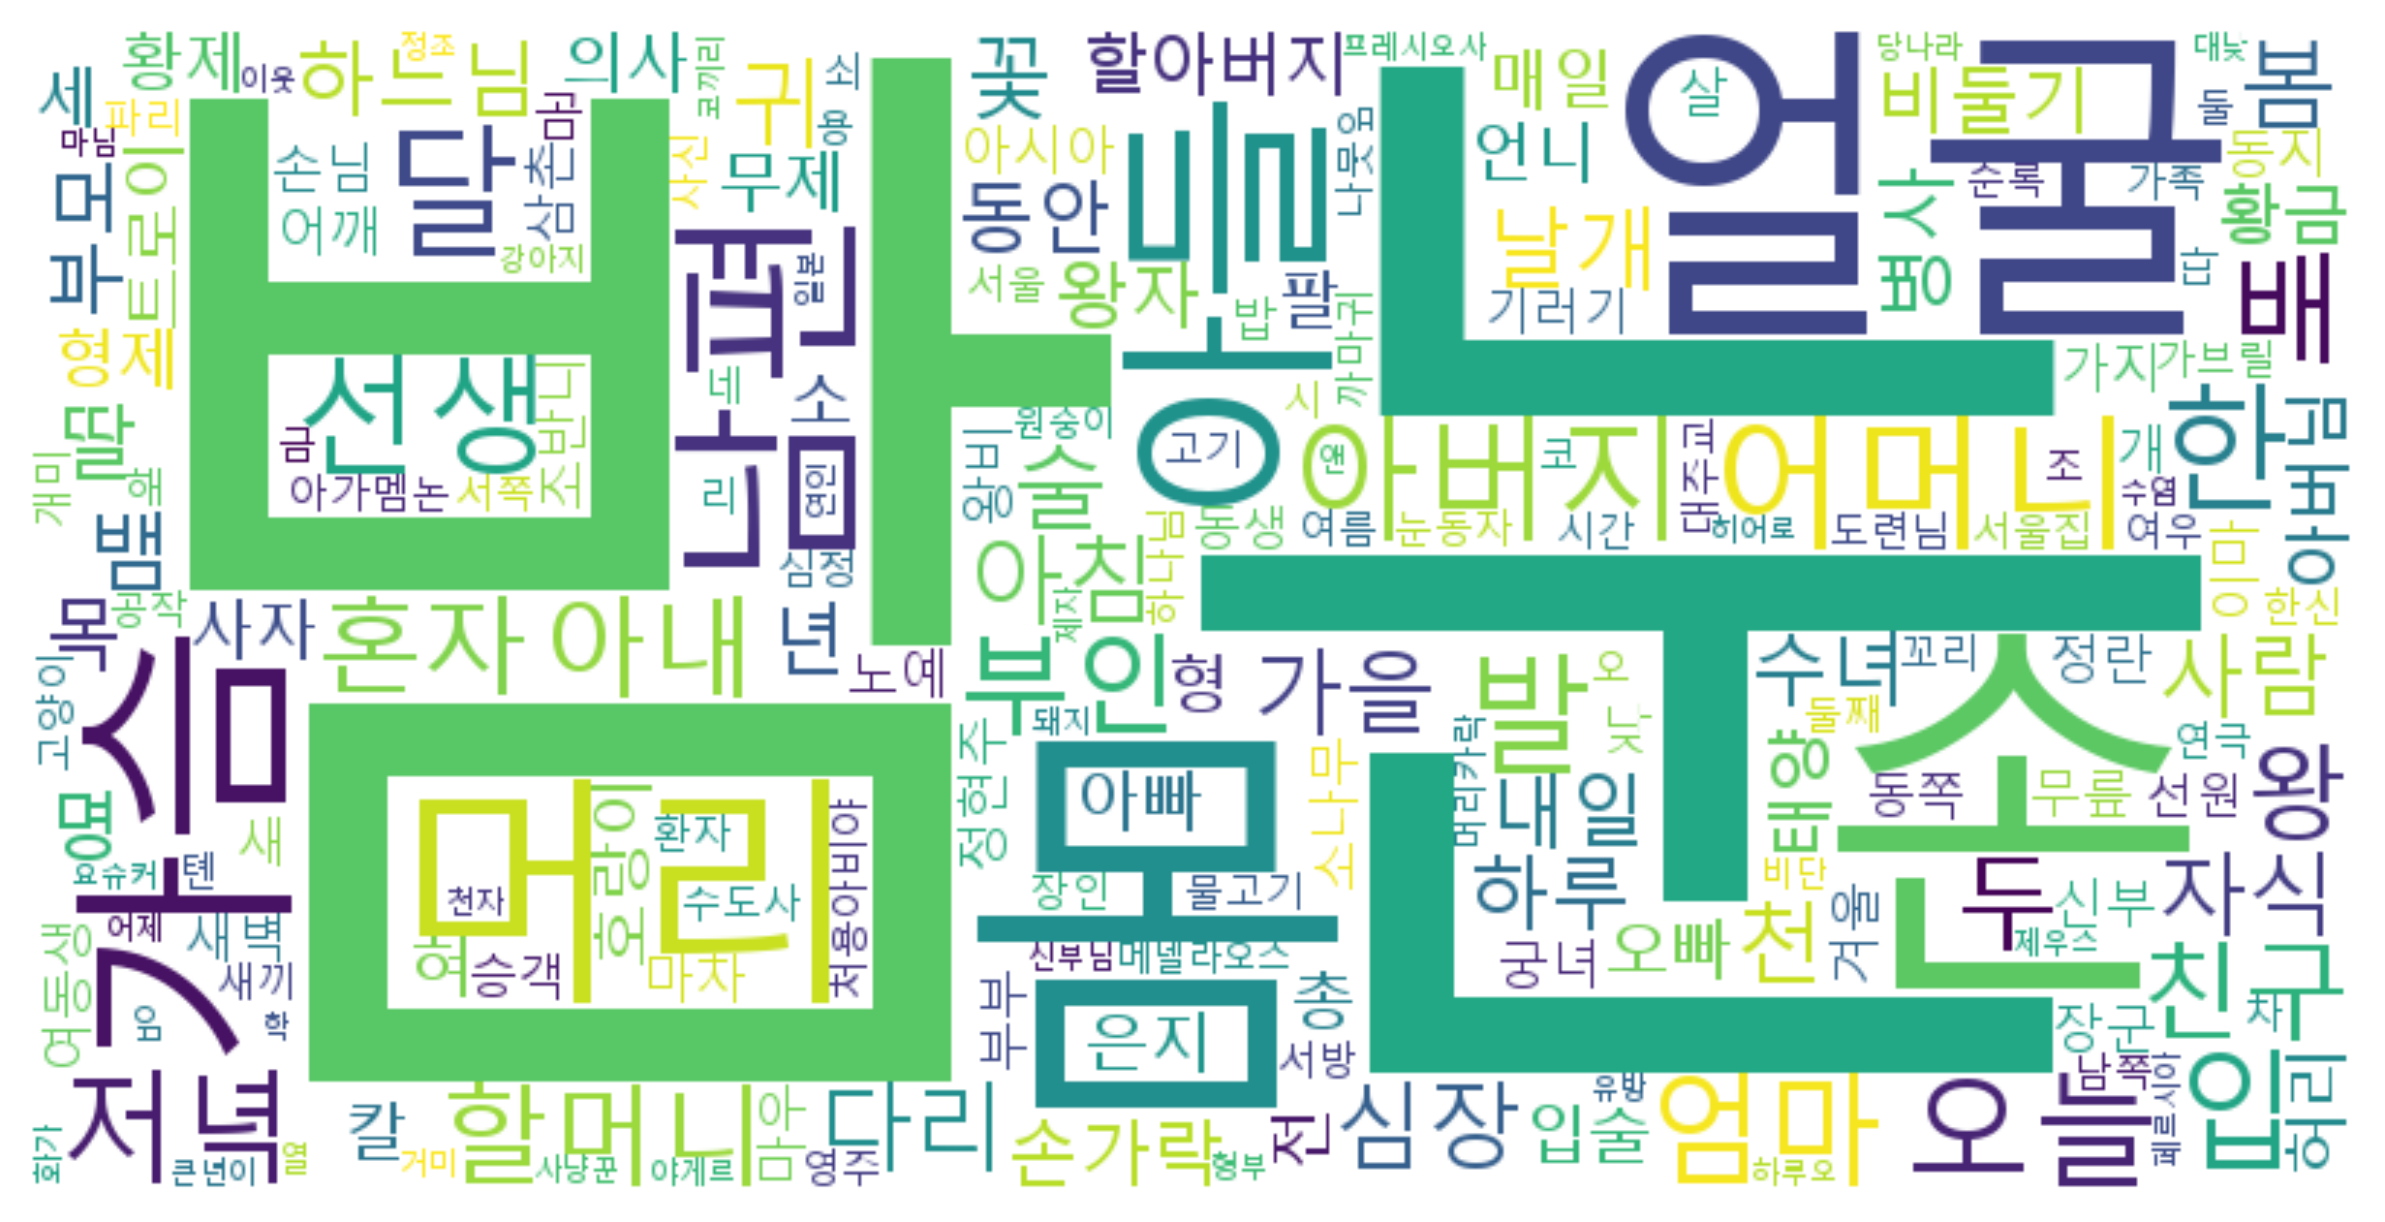

#### 상처 ####


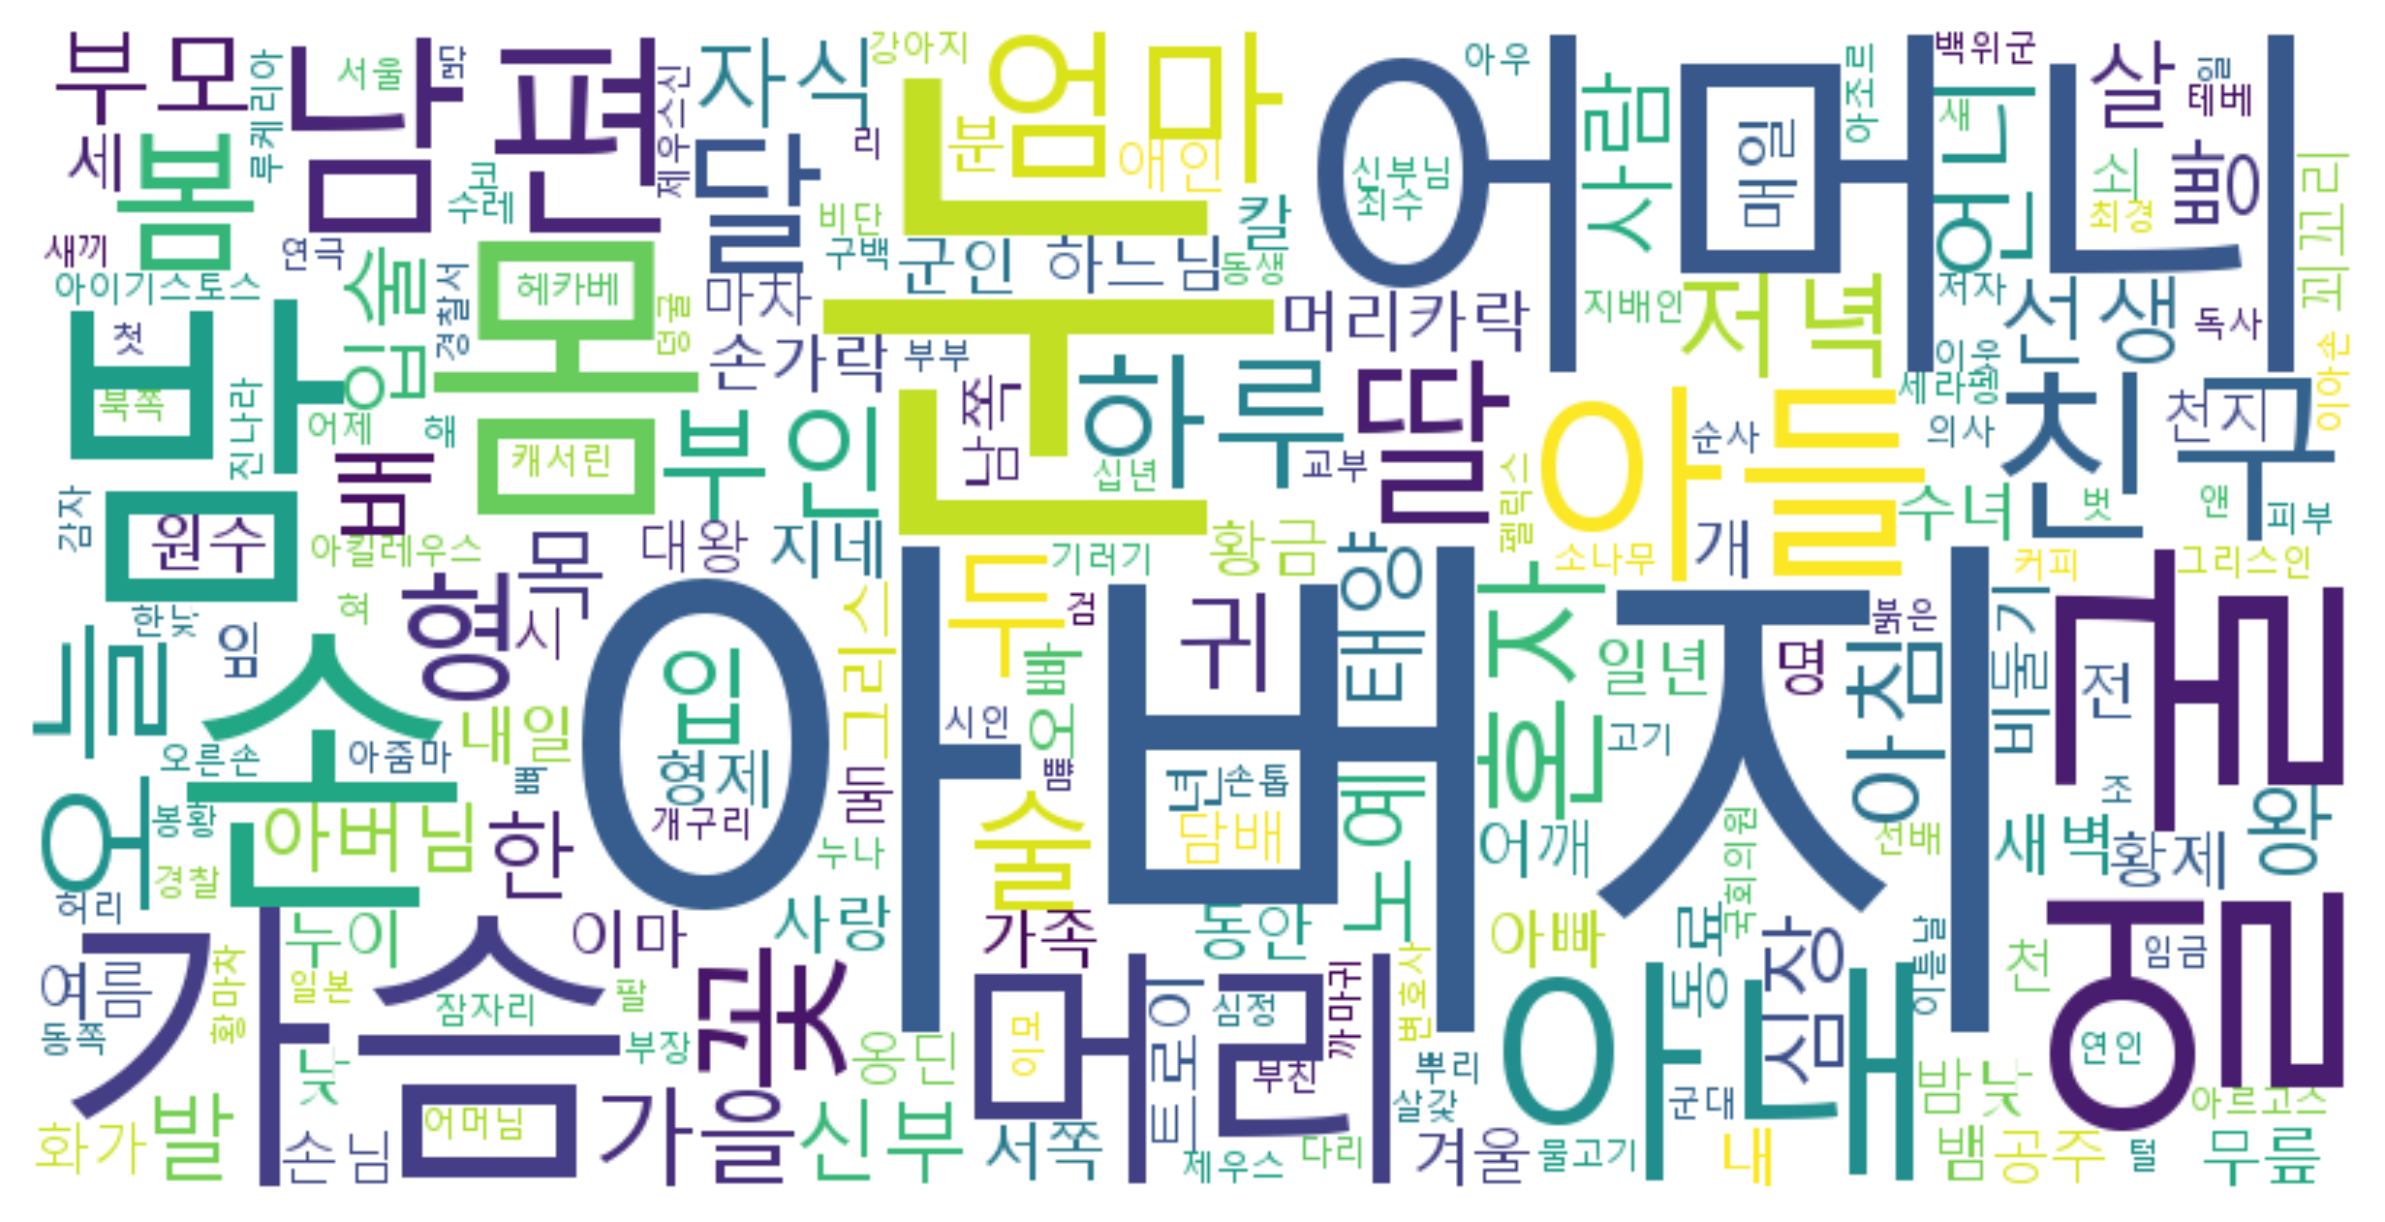

#### 슬픔 ####


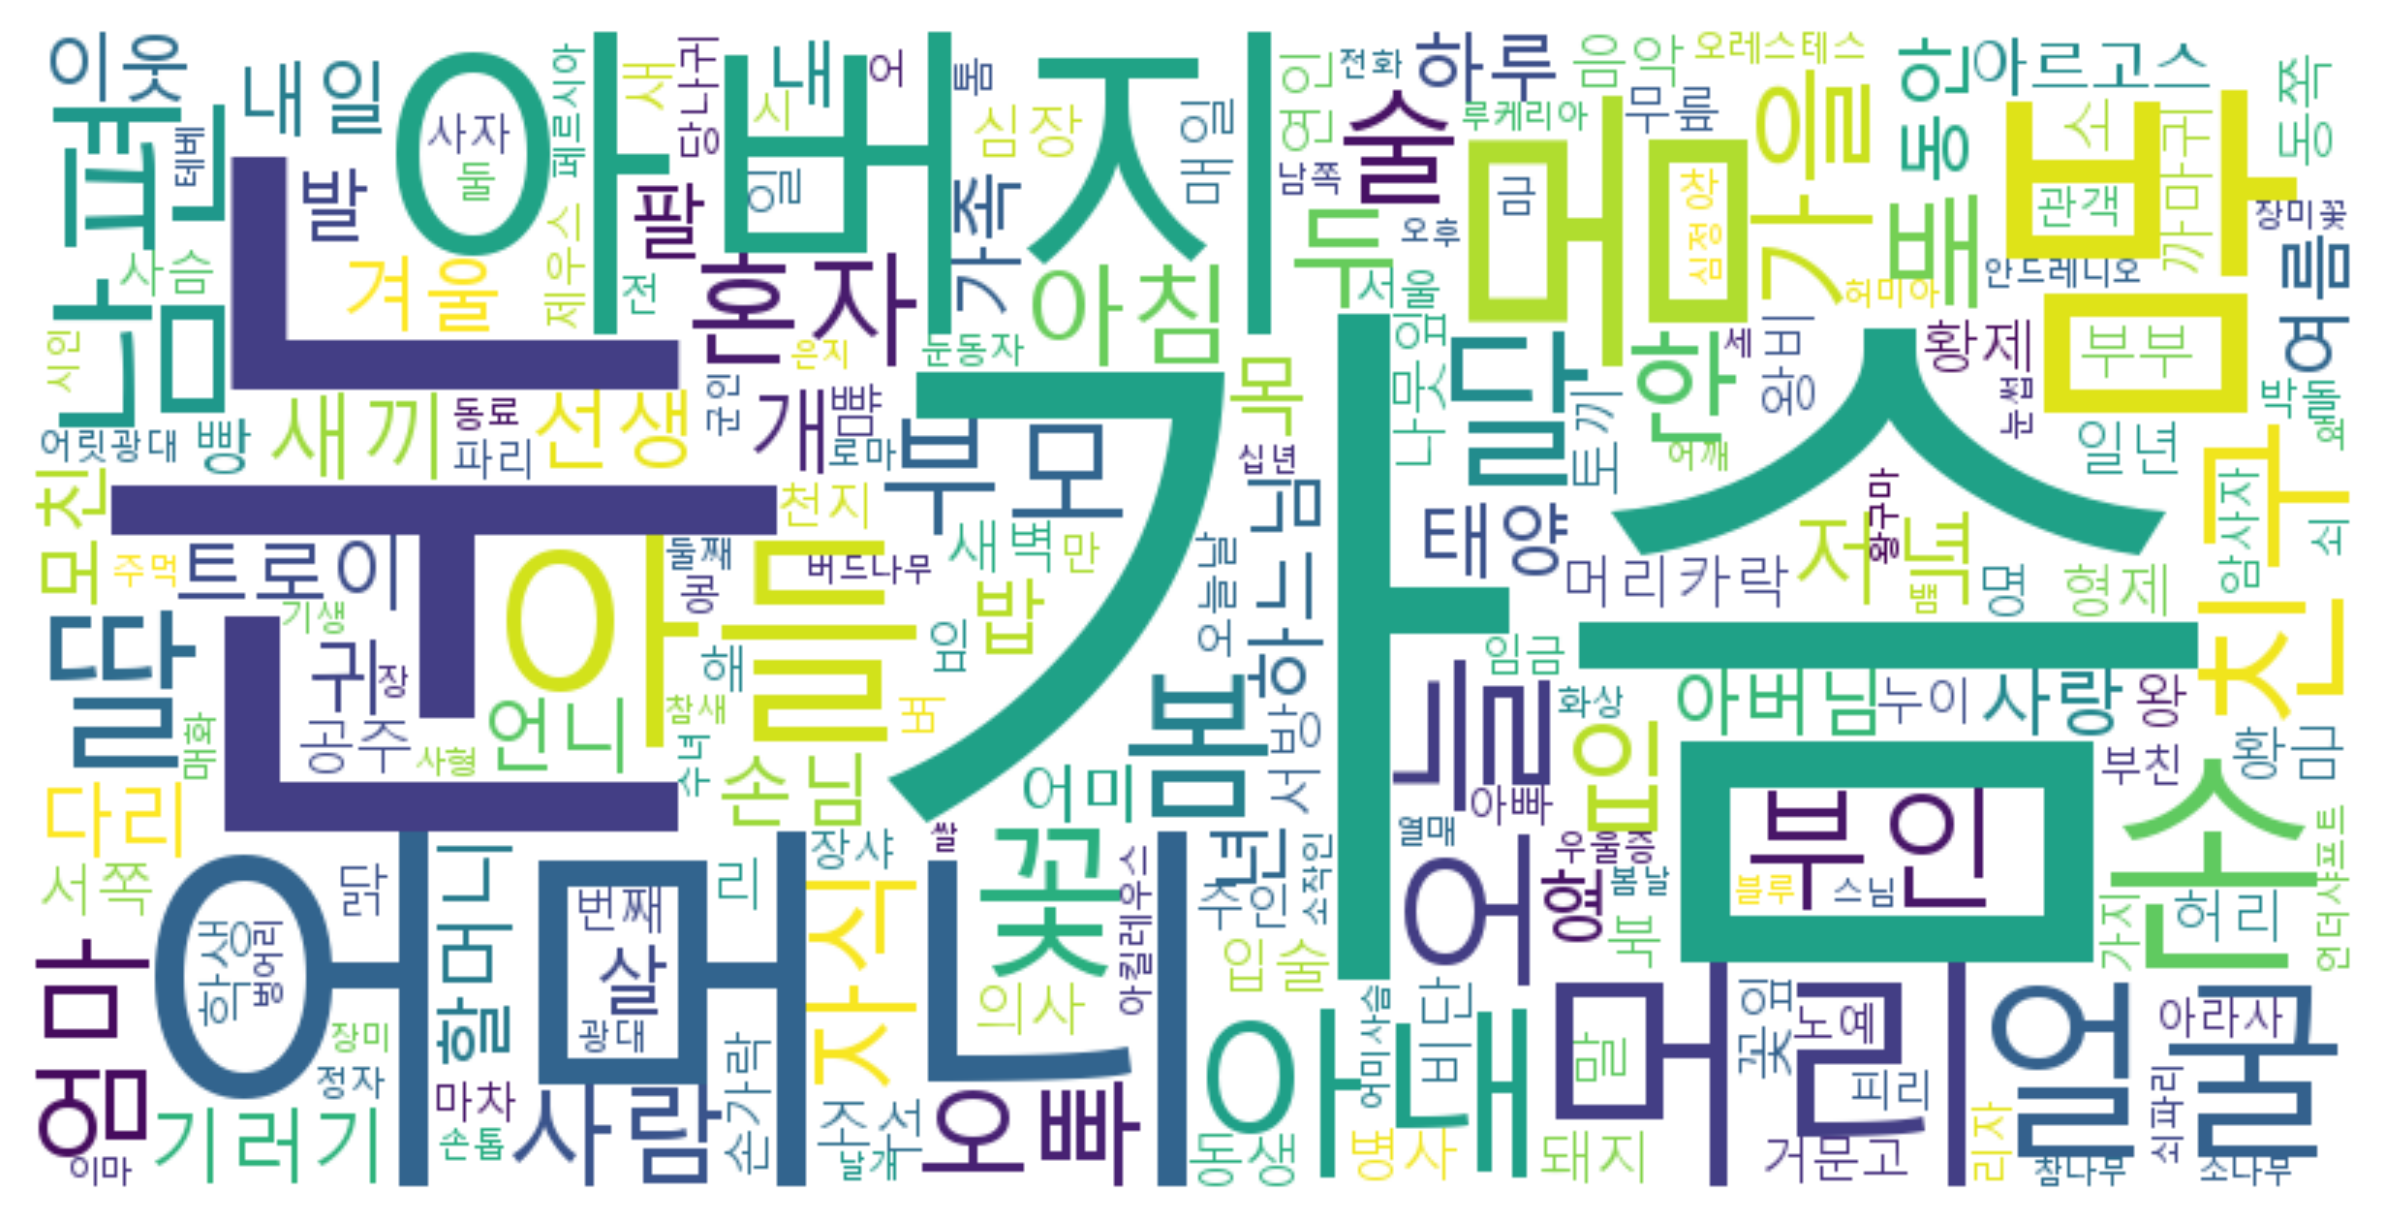

In [83]:
for emotion in emotion_ner.keys():
    draw_wordcloud(emotion)